# BDB submission

The following script contains the data processing and modeling that went into creating a frame-by-frame catch probability model, aggregating this to play by play catch probability, and creating an "expected catch added" metric.

## Import Packages

The first step is to import all of the necessary libraries and setup our environment.

In [2]:
#Import required libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle, Circle
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, classification_report, confusion_matrix, accuracy_score, roc_auc_score, log_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats


pd.set_option('display.max_columns', None)  #Show all columns
pd.set_option('display.width', None)        #Auto-detect width
pd.set_option('display.max_colwidth', None) #Show full column content
pd.set_option('display.max_rows', 500)

## Google Colab + Kaggle API Setup

This section sets up the Kaggle API to download competition data directly into Colab.

In [3]:
# ============================================================================
# KAGGLE API SETUP FOR GOOGLE COLAB
# ============================================================================

# Step 1: Install Kaggle API
!pip install -q kaggle

# Step 2: Setup Kaggle credentials
import os

# Create the .kaggle directory
os.makedirs(os.path.expanduser('~/.kaggle'), exist_ok=True)

# Write your API credentials
kaggle_credentials = {
    "username": "alexandernanda",
    "key": "b78aee0fa7ecd023dd76eac12b15fb89"
}

import json
with open(os.path.expanduser('~/.kaggle/kaggle.json'), 'w') as f:
    json.dump(kaggle_credentials, f)

# Set permissions (required by Kaggle API)
!chmod 600 ~/.kaggle/kaggle.json

print("Kaggle API configured successfully!")

Kaggle API configured successfully!


In [4]:
# ============================================================================
# DOWNLOAD COMPETITION DATA
# ============================================================================

# Create data directory
!mkdir -p ./data

# Download the competition data
# Note: You must accept the competition rules on Kaggle first!

!kaggle competitions download -c nfl-big-data-bowl-2026-analytics -p ./data

# Unzip the data
!unzip -q -o ./data/nfl-big-data-bowl-2026-analytics.zip -d ./data

# List what we downloaded
print("\nDownloaded files:")
!ls -la ./data/

 98% 101M/103M [00:00<00:00, 1.05GB/s]
100% 103M/103M [00:00<00:00, 1.05GB/s]

Downloaded files:
total 105436
drwxr-xr-x 3 root root      4096 Dec 17 15:53 .
drwxr-xr-x 1 root root      4096 Dec 17 15:53 ..
drwxr-xr-x 3 root root      4096 Dec 17 15:53 114239_nfl_competition_files_published_analytics_final
-rw-r--r-- 1 root root 107953117 Sep 23 18:37 nfl-big-data-bowl-2026-analytics.zip


In [5]:
# ============================================================================
# SET DATA PATH FOR COLAB
# ============================================================================

import os

# Find the correct data path after unzip
if os.path.exists('./data/nfl-big-data-bowl-2026-analytics'):
    data_path = './data/nfl-big-data-bowl-2026-analytics'
elif os.path.exists('./data'):
    data_path = './data'
else:
    data_path = '.'

print(f"Using data path: {data_path}")
print(f"\nContents:")
for item in os.listdir(data_path):
    print(f"  {item}")

Using data path: ./data

Contents:
  nfl-big-data-bowl-2026-analytics.zip
  114239_nfl_competition_files_published_analytics_final


## Load in the files

The next step is to access the Kaggle data and load in all of our necessary data.

In [6]:
# ============================================================================
# LOAD DATA - Works for both Kaggle and Colab
# ============================================================================

import os

# Check if running on Kaggle or Colab
if os.path.exists('/kaggle/input/nfl-big-data-bowl-2026-analytics'):
    # Running on Kaggle
    data_path = '/kaggle/input/nfl-big-data-bowl-2026-analytics'
    train_path = os.path.join(data_path, '114239_nfl_competition_files_published_analytics_final', 'train')
    supplementary_path = os.path.join(data_path, '114239_nfl_competition_files_published_analytics_final')
else:
    # Running on Colab - use the path from Kaggle API download
    # Adjust these paths based on your unzipped folder structure
    data_path = './data'

    # Try to find train folder
    possible_train_paths = [
        os.path.join(data_path, 'train'),
        os.path.join(data_path, '114239_nfl_competition_files_published_analytics_final', 'train'),
        os.path.join(data_path, 'nfl-big-data-bowl-2026', 'train'),
    ]
    train_path = next((p for p in possible_train_paths if os.path.exists(p)), possible_train_paths[0])

    # Try to find supplementary folder
    possible_supp_paths = [
        data_path,
        os.path.join(data_path, '114239_nfl_competition_files_published_analytics_final'),
        os.path.join(data_path, 'nfl-big-data-bowl-2026'),
    ]
    supplementary_path = next((p for p in possible_supp_paths if os.path.exists(os.path.join(p, 'supplementary_data.csv'))), possible_supp_paths[0])

print(f"Data path: {data_path}")
print(f"Train path: {train_path}")
print(f"Supplementary path: {supplementary_path}")

# Get all CSV files in the train folder
csv_files = [f for f in os.listdir(train_path) if f.endswith('.csv')]
print(f"\nTotal CSV files in train folder: {len(csv_files)}")

# Import all training files into a dictionary
dataframes = {}
for file in csv_files:
    file_path = os.path.join(train_path, file)
    df_name = file.replace('.csv', '')
    dataframes[df_name] = pd.read_csv(file_path)
    print(f"Loaded {df_name}: {dataframes[df_name].shape}")

# Load supplementary CSV files
print(f"\nLoading supplementary data...")
supp_files = os.listdir(supplementary_path)
for file in supp_files:
    if file.endswith('.csv'):
        file_path = os.path.join(supplementary_path, file)
        df_name = file.replace('.csv', '')
        dataframes[df_name] = pd.read_csv(file_path)
        print(f"Loaded supplementary {df_name}: {dataframes[df_name].shape}")

print(f"\nTotal datasets loaded: {len(dataframes)}")
print("Available dataframes:", list(dataframes.keys()))


Data path: ./data
Train path: ./data/114239_nfl_competition_files_published_analytics_final/train
Supplementary path: ./data/114239_nfl_competition_files_published_analytics_final

Total CSV files in train folder: 36
Loaded input_2023_w09: (252796, 23)
Loaded input_2023_w06: (270676, 23)
Loaded output_2023_w03: (36080, 6)
Loaded output_2023_w17: (33076, 6)
Loaded input_2023_w18: (254917, 23)
Loaded input_2023_w01: (285714, 23)
Loaded output_2023_w10: (29008, 6)
Loaded input_2023_w03: (297757, 23)
Loaded input_2023_w16: (316417, 23)
Loaded input_2023_w04: (272475, 23)
Loaded output_2023_w02: (32180, 6)
Loaded output_2023_w07: (27443, 6)
Loaded output_2023_w18: (29682, 6)
Loaded output_2023_w06: (31162, 6)
Loaded output_2023_w12: (32156, 6)
Loaded input_2023_w17: (277582, 23)
Loaded output_2023_w08: (33017, 6)
Loaded output_2023_w05: (29319, 6)
Loaded output_2023_w01: (32088, 6)
Loaded input_2023_w05: (254779, 23)
Loaded output_2023_w15: (32715, 6)
Loaded input_2023_w07: (233597, 23)
Loa

/tmp/ipython-input-2723934217.py:57: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  dataframes[df_name] = pd.read_csv(file_path)


Now that the data is loaded, let's call of it in. The data consists of input (18 files each representing a week of the season), output, and supplementary data.

In [7]:
week1_input = dataframes['input_2023_w01']
week2_input = dataframes['input_2023_w02']
week3_input = dataframes['input_2023_w03']
week4_input = dataframes['input_2023_w04']
week5_input = dataframes['input_2023_w05']
week6_input = dataframes['input_2023_w06']
week7_input = dataframes['input_2023_w07']
week8_input = dataframes['input_2023_w08']
week9_input = dataframes['input_2023_w09']
week10_input = dataframes['input_2023_w10']
week11_input = dataframes['input_2023_w11']
week12_input = dataframes['input_2023_w12']
week13_input = dataframes['input_2023_w13']
week14_input = dataframes['input_2023_w14']
week15_input = dataframes['input_2023_w15']
week16_input = dataframes['input_2023_w16']
week17_input = dataframes['input_2023_w17']

week1_output = dataframes['output_2023_w01']
week2_output = dataframes['output_2023_w02']
week3_output = dataframes['output_2023_w03']
week4_output = dataframes['output_2023_w04']
week5_output = dataframes['output_2023_w05']
week6_output = dataframes['output_2023_w06']
week7_output = dataframes['output_2023_w07']
week8_output = dataframes['output_2023_w08']
week9_output = dataframes['output_2023_w09']
week10_output = dataframes['output_2023_w10']
week11_output = dataframes['output_2023_w11']
week12_output = dataframes['output_2023_w12']
week13_output = dataframes['output_2023_w13']
week14_output = dataframes['output_2023_w14']
week15_output = dataframes['output_2023_w15']
week16_output = dataframes['output_2023_w16']
week17_output = dataframes['output_2023_w17']

supplementary_data = dataframes['supplementary_data']

# --- ADD THIS FIX HERE ---
# Rename supplementary columns to match tracking data (camelCase -> snake_case)
if 'gameId' in supplementary_data.columns:
    supplementary_data = supplementary_data.rename(columns={
        "gameId": "game_id",
        "playId": "play_id",
        "nflId": "nfl_id"
    })

## Data Wrangling

To begin, let's look at the input data and identify the targeted receiver in every frame. Keep in mind, the input data contains player tracking information from *before the ball is thrown*.

In [8]:
processed_dataframes = []
for df_name, df in dataframes.items():
    if df_name.startswith('input'):
        #Filter for 'player_to_predict' == True and 'player_role' == 'Targeted Receiver'
        filtered_df = df[(df["player_to_predict"] == True) & (df["player_role"] == "Targeted Receiver")]
        #Sort by 'frame_id' and 'player_name'
        sorted_df = filtered_df.sort_values(['frame_id', 'player_name'])
        #Group by 'play_id', 'game_id' and select the last entry for each group
        final_df = sorted_df.groupby(['play_id', 'game_id']).tail(1)
        processed_dataframes.append(final_df)

receivers_input = pd.concat(processed_dataframes, ignore_index=True)
receivers_input

,game_id,play_id,player_to_predict,nfl_id,frame_id,play_direction,absolute_yardline_number,player_name,player_height,player_weight,player_birth_date,player_position,player_side,player_role,x,y,s,a,dir,o,num_frames_output,ball_land_x,ball_land_y
0,2023110509,1738,True,41282,9,left,30,Davante Adams,6-1,215,1992-12-24,WR,Offense,Targeted Receiver,30.99,9.84,0.52,0.50,229.43,119.44,8,30.719999,11.180000
1,2023110600,412,True,54475,10,left,54,Garrett Wilson,6-0,192,2000-07-22,WR,Offense,Targeted Receiver,55.65,37.17,2.89,3.14,19.65,233.63,6,56.119999,36.950001
2,2023110600,2558,True,54475,11,right,76,Garrett Wilson,6-0,192,2000-07-22,WR,Offense,Targeted Receiver,75.00,13.43,2.98,2.53,186.63,72.99,7,74.730003,12.160000
3,2023110505,3355,True,44896,14,left,11,Chris Godwin Jr.,6-1,209,1996-02-27,WR,Offense,Targeted Receiver,10.72,41.96,4.11,2.35,325.14,286.91,10,8.080000,40.090000
4,2023110511,329,True,55889,14,left,95,Dalton Kincaid,6-4,240,1999-10-18,TE,Offense,Targeted Receiver,95.99,38.14,5.55,2.20,344.81,77.95,8,95.610001,42.889999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14103,2023091711,4524,True,52423,58,right,30,Jerry Jeudy,6-1,192,1999-04-24,WR,Offense,Targeted Receiver,37.71,47.45,3.37,2.11,55.25,110.85,12,35.680000,48.360001
14104,2023091700,2147,True,54473,59,right,30,Drake London,6-5,210,2001-07-24,WR,Offense,Targeted Receiver,50.62,9.80,8.58,2.81,196.41,204.49,8,42.480000,2.650000
14105,2023091800,1854,True,55904,59,left,78,Jonathan Mingo,6-2,225,2001-04-20,WR,Offense,Targeted Receiver,66.10,17.99,6.83,2.28,210.53,177.40,9,64.769997,11.850000
14106,2023091710,4021,True,46705,61,right,52,Allen Lazard,6-5,227,1995-12-11,WR,Offense,Targeted Receiver,69.57,5.70,7.51,1.22,98.96,35.09,19,79.169998,0.490000


The next step is to get passer information. This is also from the input since the output data ony contains targeted receiver and nearest defender telemetry.

* X/Y at Ball Released
* Speed at Ball Released
* Orientation at Ball Released
* Direction at Ball Released
* Acceleration at Ball Released
* Distance from Targeted Receiver at Ball Released
* Defenders within 2 Yards at Ball Released
* Defenders within 5 Yards at Ball Released
* Distance from Sideline at Ball Released
* Number of Players in Area at Ball Released (5 Yards)

In [9]:
#Get QB data
qb_dataframes = []
for df_name, df in dataframes.items():
    if df_name.startswith('input'):
        #Filter for QBs
        filtered_df = df[(df["player_position"] == "QB")]
        #Sort by 'frame_id' and 'player_name'
        sorted_df = filtered_df.sort_values(['frame_id', 'player_name'])
        #Group by 'play_id', 'game_id' and select the last entry for each group
        final_df = sorted_df.groupby(['play_id', 'game_id']).tail(1)
        qb_dataframes.append(final_df)

qb_dataframes = pd.concat(qb_dataframes)
qb_dataframes

,game_id,play_id,player_to_predict,nfl_id,frame_id,play_direction,absolute_yardline_number,player_name,player_height,player_weight,player_birth_date,player_position,player_side,player_role,x,y,s,a,dir,o,num_frames_output,ball_land_x,ball_land_y
177708,2023110509,1738,False,56000,9,left,30,Aidan O'Connell,6-3,210,1998-09-01,QB,Offense,Passer,32.13,23.72,1.72,2.06,122.49,253.36,8,30.719999,11.180000
231381,2023110600,412,False,53431,10,left,54,Zach Wilson,6-2,208,1999-08-03,QB,Offense,Passer,56.24,27.54,1.13,0.41,39.05,358.06,6,56.119999,36.950001
242800,2023110600,2558,False,53431,11,right,76,Zach Wilson,6-2,208,1999-08-03,QB,Offense,Passer,73.76,23.31,1.19,0.07,231.68,199.79,7,74.730003,12.160000
111289,2023110505,3355,False,46070,14,left,11,Baker Mayfield,6-1,215,1995-04-14,QB,Offense,Passer,14.36,24.02,2.49,0.95,67.86,1.06,10,8.080000,40.090000
210331,2023110511,329,False,46076,14,left,95,Josh Allen,6-5,237,1996-05-21,QB,Offense,Passer,99.84,30.25,1.25,1.37,23.42,324.95,8,95.610001,42.889999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236495,2023091711,4524,False,38605,58,right,30,Russell Wilson,5-11,215,1988-11-29,QB,Offense,Passer,21.85,24.22,5.09,0.67,32.92,88.48,12,35.680000,48.360001
261193,2023091800,1854,False,55865,59,left,78,Bryce Young,6-0,194,2001-07-25,QB,Offense,Passer,80.50,11.95,2.88,3.95,211.56,272.03,9,64.769997,11.850000
25372,2023091700,2147,False,54539,59,right,30,Desmond Ridder,6-4,215,1999-08-31,QB,Offense,Passer,25.47,7.50,8.38,1.39,140.56,123.38,8,42.480000,2.650000
217319,2023091710,4021,False,53431,61,right,52,Zach Wilson,6-2,208,1999-08-03,QB,Offense,Passer,37.82,18.48,2.15,3.33,147.34,126.42,19,79.169998,0.490000


Now, we will engineer a few variables including coordinates when the QB releases the ball and the distance from the sideline.

In [10]:
#Rename columns for final dataset
qb_dataframes = qb_dataframes.rename(columns = {'x': 'qb_release_x', 'y': 'qb_release_y', 's': 'qb_release_s',
                                                'o': 'qb_release_o', 'dir': 'qb_release_dir', 'a': 'qb_release_a'})

#Engineeer distance from the sideline
qb_dataframes["distance_from_sideline"] = np.where(qb_dataframes["qb_release_y"]>=26.65,
                                                     53.3-qb_dataframes["qb_release_y"],
                                                    0+qb_dataframes["qb_release_y"])

qb_dataframes = qb_dataframes.rename(columns = {'distance_from_sideline': 'qb_distance_from_sideline'})


Bring in all 22 players on a play to get proximity features to QB

In [11]:
#Get all of the tracking information
tracking_df = pd.concat([df for df_name, df in dataframes.items() if df_name.startswith('input')],
                        ignore_index=True)

#Get the unique identifiers for the ball released frame of each play
ball_released_frames = qb_dataframes[['game_id', 'play_id', 'frame_id']].copy()

#Filter the data to get only the 22 players on a play
ball_released_player_tracking = tracking_df.merge(
    ball_released_frames,
    on = ['game_id', 'play_id', 'frame_id']
)

#Grab the QB info we want
qb_information = qb_dataframes[['game_id', 'play_id', 'player_name', 'player_side','qb_release_x', 'qb_release_y',
                                'qb_release_s', 'qb_release_o', "qb_release_a", "qb_release_dir", "qb_distance_from_sideline"]].rename(
                                columns = {'player_side': 'qb_side'}
                                )


#Join player information at ball released with the QB information
merged_df = ball_released_player_tracking.merge(
    qb_information,
    on = ['game_id', 'play_id']
)

#Calculate Euclidean distance from each player to QB
merged_df["distance_to_qb"] = np.sqrt(
    (merged_df['x'] - merged_df['qb_release_x'])**2 +
    (merged_df['y'] - merged_df['qb_release_y'])**2
)

#Create boolean flags for our conditions
merged_df['not_qb'] = merged_df['distance_to_qb'] > 0.01
merged_df['is_defender'] = (merged_df['player_side'] != merged_df['qb_side']) & merged_df['not_qb']

#Create proximity features
merged_df['defenders_within_2_yards_qb'] = merged_df['is_defender'] & (merged_df['distance_to_qb'] <= 2)
merged_df['defenders_within_5_yards_qb'] = merged_df['is_defender'] & (merged_df['distance_to_qb'] <= 5)
merged_df['player_within_5_yards_qb'] = merged_df['not_qb'] & (merged_df['distance_to_qb'] <= 5)

#ggregate features at the play level
proximity_counts = merged_df.groupby(['game_id', 'play_id']).agg(
    num_defenders_within_2_yards_qb=('defenders_within_2_yards_qb', 'sum'),
    num_defenders_within_5_yards_qb=('defenders_within_5_yards_qb', 'sum'),
    num_players_within_5_yards_qb=('player_within_5_yards_qb', 'sum')
).reset_index()

#Merge back to the original dataframe
qb_dataframes = qb_dataframes.merge(
    proximity_counts,
    on=['game_id', 'play_id'],
    how='left'
)

#Fill missing values
count_cols = ['num_defenders_within_2_yards_qb', 'num_defenders_within_5_yards_qb', 'num_players_within_5_yards_qb']
for col in count_cols:
    qb_dataframes[col] = qb_dataframes[col].fillna(0).astype(int)

qb_dataframes

,game_id,play_id,player_to_predict,nfl_id,frame_id,play_direction,absolute_yardline_number,player_name,player_height,player_weight,player_birth_date,player_position,player_side,player_role,qb_release_x,qb_release_y,qb_release_s,qb_release_a,qb_release_dir,qb_release_o,num_frames_output,ball_land_x,ball_land_y,qb_distance_from_sideline,num_defenders_within_2_yards_qb,num_defenders_within_5_yards_qb,num_players_within_5_yards_qb
0,2023110509,1738,False,56000,9,left,30,Aidan O'Connell,6-3,210,1998-09-01,QB,Offense,Passer,32.13,23.72,1.72,2.06,122.49,253.36,8,30.719999,11.180000,23.72,0,0,1
1,2023110600,412,False,53431,10,left,54,Zach Wilson,6-2,208,1999-08-03,QB,Offense,Passer,56.24,27.54,1.13,0.41,39.05,358.06,6,56.119999,36.950001,25.76,0,0,0
2,2023110600,2558,False,53431,11,right,76,Zach Wilson,6-2,208,1999-08-03,QB,Offense,Passer,73.76,23.31,1.19,0.07,231.68,199.79,7,74.730003,12.160000,23.31,0,0,1
3,2023110505,3355,False,46070,14,left,11,Baker Mayfield,6-1,215,1995-04-14,QB,Offense,Passer,14.36,24.02,2.49,0.95,67.86,1.06,10,8.080000,40.090000,24.02,0,0,2
4,2023110511,329,False,46076,14,left,95,Josh Allen,6-5,237,1996-05-21,QB,Offense,Passer,99.84,30.25,1.25,1.37,23.42,324.95,8,95.610001,42.889999,23.05,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14098,2023091711,4524,False,38605,58,right,30,Russell Wilson,5-11,215,1988-11-29,QB,Offense,Passer,21.85,24.22,5.09,0.67,32.92,88.48,12,35.680000,48.360001,24.22,0,0,0
14099,2023091800,1854,False,55865,59,left,78,Bryce Young,6-0,194,2001-07-25,QB,Offense,Passer,80.50,11.95,2.88,3.95,211.56,272.03,9,64.769997,11.850000,11.95,0,1,1
14100,2023091700,2147,False,54539,59,right,30,Desmond Ridder,6-4,215,1999-08-31,QB,Offense,Passer,25.47,7.50,8.38,1.39,140.56,123.38,8,42.480000,2.650000,7.50,0,0,0
14101,2023091710,4021,False,53431,61,right,52,Zach Wilson,6-2,208,1999-08-03,QB,Offense,Passer,37.82,18.48,2.15,3.33,147.34,126.42,19,79.169998,0.490000,18.48,0,0,0


In [12]:
#Define the columns that were just added
count_cols = ['num_defenders_within_2_yards_qb',
              'num_defenders_within_5_yards_qb',
              'num_players_within_5_yards_qb']

print(qb_dataframes[count_cols].describe())

       num_defenders_within_2_yards_qb  num_defenders_within_5_yards_qb  \
count                     14103.000000                     14103.000000   
mean                          0.003120                         0.020421   
std                           0.058258                         0.159358   
min                           0.000000                         0.000000   
25%                           0.000000                         0.000000   
50%                           0.000000                         0.000000   
75%                           0.000000                         0.000000   
max                           2.000000                         3.000000   

       num_players_within_5_yards_qb  
count                   14103.000000  
mean                        0.097213  
std                         0.334271  
min                         0.000000  
25%                         0.000000  
50%                         0.000000  
75%                         0.000000  
max         

In [13]:
#Select columns that we want
selected_qb_cols = ['game_id', 'play_id', 'qb_release_x', 'qb_release_y', 'qb_release_a', 'qb_release_s',
                   'qb_release_dir', 'qb_release_o', 'qb_distance_from_sideline', 'num_defenders_within_2_yards_qb',
                   'num_defenders_within_5_yards_qb', 'num_players_within_5_yards_qb']

qb_dataframes = qb_dataframes[selected_qb_cols]



With all of the QB data wrangled in the input, we now move to the output data, which gives us player tracking for when the ball is released. Our goal now is to use the input data to identify the targeted receiver and separate that from the other rows which represent the nearest defenders. Pivot the coordinates fo the defenders to be merged with receiver data.

This will result in a singular entry for each frame that represents the targeted receiver's information while also including coordinates for the nearest defenders.

In [14]:
#Get the output data frames
output_dataframes = []
for df_name, df in dataframes.items():
    if df_name.startswith('output'):
        output_dataframes.append(df)

#Concatenate all processed dataframes into a single result dataframe
outputs_df = pd.concat(output_dataframes, ignore_index=True)
outputs_df

,game_id,play_id,nfl_id,frame_id,x,y
0,2023092100,78,47872,1,75.07,24.50
1,2023092100,78,47872,2,75.03,24.65
2,2023092100,78,47872,3,74.97,24.73
3,2023092100,78,47872,4,74.92,24.77
4,2023092100,78,47872,5,74.87,24.75
...,...,...,...,...,...,...
562931,2023120400,4605,53434,6,66.59,11.42
562932,2023120400,4605,53434,7,66.59,11.36
562933,2023120400,4605,53434,8,66.61,11.28
562934,2023120400,4605,53434,9,66.66,11.18


Now onto the actually pivoting all the data

In [15]:
# --- Step 1: Merge output with receiver target info ---
# This identifies WHO the target is for each play
df_merged = outputs_df.merge(
    receivers_input[['game_id', 'play_id', 'nfl_id']],
    on=['game_id', 'play_id'],
    how='left',
    suffixes=('', '_target')
)

# --- Step 2: Isolate Receiver Data
# We need the receiver's X, Y for every frame to compare against others
receiver_features = df_merged[df_merged['nfl_id'] == df_merged['nfl_id_target']][
    ['game_id', 'play_id', 'frame_id', 'x', 'y']
].rename(columns={
    'x': 'receiver_x',
    'y': 'receiver_y'
})

# Merge these coordinates back onto the main dataframe
df_full_context = df_merged.merge(
    receiver_features,
    on=['game_id', 'play_id', 'frame_id'],
    how='inner' # Inner join removes plays where receiver isn't in tracking data
)

# --- Step 3: Calculate Distance to Receiver ---
df_full_context['dist_to_receiver'] = np.sqrt(
    (df_full_context['x'] - df_full_context['receiver_x'])**2 +
    (df_full_context['y'] - df_full_context['receiver_y'])**2
)

# --- Step 4: Filter for Defenders Only ---
# Logic: It is a defender if their club is DIFFERENT from the receiver's club
# AND they are not the football itself.
defender_df = df_full_context[
    (df_full_context['nfl_id'] != df_full_context['nfl_id_target'])
].copy()

defender_df['within_1'] = (defender_df['dist_to_receiver'] <= 1).astype(int)
defender_df['within_3'] = (defender_df['dist_to_receiver'] <= 3).astype(int)
defender_df['within_5'] = (defender_df['dist_to_receiver'] <= 5).astype(int)

# Group by frame to get the total counts per frame
density_features = defender_df.groupby(['game_id', 'play_id', 'frame_id'])[[
    'within_1', 'within_3', 'within_5'
]].sum().reset_index()

# Rename columns for clarity
density_features.columns = [
    'game_id', 'play_id', 'frame_id',
    'defenders_within_1_yard',
    'defenders_within_3_yards',
    'defenders_within_5_yards'
]


# --- Step 5: Rank Defenders by Proximity ---
defender_df = defender_df.sort_values(['game_id', 'play_id', 'frame_id', 'dist_to_receiver'])

# Create a rank (1 = closest, 2 = second closest, etc.)
defender_df['defender_rank'] = defender_df.groupby(
    ['game_id', 'play_id', 'frame_id']
).cumcount() + 1

# Limit to top N defenders if desired (e.g., top 7 closest) to save memory
defender_df = defender_df[defender_df['defender_rank'] <= 5]

# --- Step 6: Pivot Defenders to Wide Format ---
# We want columns like: defender1_nfl_id, defender1_x, defender1_dist, etc.
defender_pivot = defender_df.pivot_table(
    index=['game_id', 'play_id', 'frame_id'],
    columns='defender_rank',
    values=['nfl_id', 'x', 'y', 'dist_to_receiver'],
    aggfunc='first'
)

# Flatten the MultiIndex columns
defender_pivot.columns = [f'defender{rank}_{col}' for col, rank in defender_pivot.columns]
defender_pivot = defender_pivot.reset_index()

# --- Step 7: Final Stacked Output ---
# Start with the receiver data we isolated in Step 2 (expanded with other cols)
final_receiver_data = df_full_context[df_full_context['nfl_id'] == df_full_context['nfl_id_target']].copy()

# Merge the pivoted defender data onto the receiver data
final_stacked_output = final_receiver_data.merge(
    defender_pivot,
    on=['game_id', 'play_id', 'frame_id'],
    how='left'
)

# Merge 2: Add the Density Counts (New Feature)
final_stacked_output = final_stacked_output.merge(
    density_features,
    on=['game_id', 'play_id', 'frame_id'],
    how='left'
)

final_stacked_output = final_stacked_output.merge(
    receivers_input.drop(columns=['nfl_id']), # Avoid duplicate nfl_id col
    on=['game_id', 'play_id'],
    how='left',
    suffixes=('', '_meta')
)

# Display result
print("Columns:", final_stacked_output.columns[:10])
final_stacked_output.head()

Columns: Index(['game_id', 'play_id', 'nfl_id', 'frame_id', 'x', 'y', 'nfl_id_target',
       'receiver_x', 'receiver_y', 'dist_to_receiver'],
      dtype='object')


,game_id,play_id,nfl_id,frame_id,x,y,nfl_id_target,receiver_x,receiver_y,dist_to_receiver,defender1_dist_to_receiver,defender2_dist_to_receiver,defender3_dist_to_receiver,defender4_dist_to_receiver,defender5_dist_to_receiver,defender1_nfl_id,defender2_nfl_id,defender3_nfl_id,defender4_nfl_id,defender5_nfl_id,defender1_x,defender2_x,defender3_x,defender4_x,defender5_x,defender1_y,defender2_y,defender3_y,defender4_y,defender5_y,defenders_within_1_yard,defenders_within_3_yards,defenders_within_5_yards,player_to_predict,frame_id_meta,play_direction,absolute_yardline_number,player_name,player_height,player_weight,player_birth_date,player_position,player_side,player_role,x_meta,y_meta,s,a,dir,o,num_frames_output,ball_land_x,ball_land_y
0,2023092100,78,47819,1,75.86,11.43,47819,75.86,11.43,0.0,1.803136,11.049348,13.093854,NaN,NaN,55888.0,52444.0,47872.0,NaN,NaN,74.58,66.86,75.07,NaN,NaN,10.16,17.84,24.50,NaN,NaN,0.0,1.0,1.0,True,19,left,81,Deebo Samuel Sr.,5-11,214,1996-01-15,WR,Offense,Targeted Receiver,76.36,11.08,6.05,3.92,301.23,335.22,9,77.169998,18.52
1,2023092100,78,47819,2,75.37,11.83,47819,75.37,11.83,0.0,1.708362,10.508306,12.824508,NaN,NaN,55888.0,52444.0,47872.0,NaN,NaN,74.25,66.75,75.03,NaN,NaN,10.54,17.84,24.65,NaN,NaN,0.0,1.0,1.0,True,19,left,81,Deebo Samuel Sr.,5-11,214,1996-01-15,WR,Offense,Targeted Receiver,76.36,11.08,6.05,3.92,301.23,335.22,9,77.169998,18.52
2,2023092100,78,47819,3,74.91,12.27,47819,74.91,12.27,0.0,1.594020,9.918488,12.460144,NaN,NaN,55888.0,52444.0,47872.0,NaN,NaN,73.96,66.71,74.97,NaN,NaN,10.99,17.85,24.73,NaN,NaN,0.0,1.0,1.0,True,19,left,81,Deebo Samuel Sr.,5-11,214,1996-01-15,WR,Offense,Targeted Receiver,76.36,11.08,6.05,3.92,301.23,335.22,9,77.169998,18.52
3,2023092100,78,47819,4,74.48,12.76,47819,74.48,12.76,0.0,1.478716,9.269175,12.018057,NaN,NaN,55888.0,52444.0,47872.0,NaN,NaN,73.69,66.74,74.92,NaN,NaN,11.51,17.86,24.77,NaN,NaN,0.0,1.0,1.0,True,19,left,81,Deebo Samuel Sr.,5-11,214,1996-01-15,WR,Offense,Targeted Receiver,76.36,11.08,6.05,3.92,301.23,335.22,9,77.169998,18.52
4,2023092100,78,47819,5,74.10,13.29,47819,74.10,13.29,0.0,1.364185,8.586181,11.485839,NaN,NaN,55888.0,52444.0,47872.0,NaN,NaN,73.47,66.85,74.87,NaN,NaN,12.08,17.89,24.75,NaN,NaN,0.0,1.0,1.0,True,19,left,81,Deebo Samuel Sr.,5-11,214,1996-01-15,WR,Offense,Targeted Receiver,76.36,11.08,6.05,3.92,301.23,335.22,9,77.169998,18.52


Now that we have the defender information, let's join it with the QB information that we wrangled earlier. Unlike the defender tracking, QB tracking information will be a constant throughout the output because it represents the QB's coordinates as the ball is being released (that doesn't change after the ball is released).

Regardless, we have a resulting row that contains receiver information, nearest defender information, and QB information.

In [16]:
final_stacked_output = final_stacked_output.merge(
    qb_dataframes,
    on = ['game_id', 'play_id'],
    how = 'left'
)

final_stacked_output

,game_id,play_id,nfl_id,frame_id,x,y,nfl_id_target,receiver_x,receiver_y,dist_to_receiver,defender1_dist_to_receiver,defender2_dist_to_receiver,defender3_dist_to_receiver,defender4_dist_to_receiver,defender5_dist_to_receiver,defender1_nfl_id,defender2_nfl_id,defender3_nfl_id,defender4_nfl_id,defender5_nfl_id,defender1_x,defender2_x,defender3_x,defender4_x,defender5_x,defender1_y,defender2_y,defender3_y,defender4_y,defender5_y,defenders_within_1_yard,defenders_within_3_yards,defenders_within_5_yards,player_to_predict,frame_id_meta,play_direction,absolute_yardline_number,player_name,player_height,player_weight,player_birth_date,player_position,player_side,player_role,x_meta,y_meta,s,a,dir,o,num_frames_output,ball_land_x,ball_land_y,qb_release_x,qb_release_y,qb_release_a,qb_release_s,qb_release_dir,qb_release_o,qb_distance_from_sideline,num_defenders_within_2_yards_qb,num_defenders_within_5_yards_qb,num_players_within_5_yards_qb
0,2023092100,78,47819,1,75.86,11.43,47819,75.86,11.43,0.0,1.803136,11.049348,13.093854,NaN,NaN,55888.0,52444.0,47872.0,NaN,NaN,74.58,66.86,75.07,NaN,NaN,10.16,17.84,24.50,NaN,NaN,0.0,1.0,1.0,True,19,left,81,Deebo Samuel Sr.,5-11,214,1996-01-15,WR,Offense,Targeted Receiver,76.36,11.08,6.05,3.92,301.23,335.22,9,77.169998,18.52,86.91,23.73,1.30,1.22,89.01,297.62,23.73,0.0,0.0,0.0
1,2023092100,78,47819,2,75.37,11.83,47819,75.37,11.83,0.0,1.708362,10.508306,12.824508,NaN,NaN,55888.0,52444.0,47872.0,NaN,NaN,74.25,66.75,75.03,NaN,NaN,10.54,17.84,24.65,NaN,NaN,0.0,1.0,1.0,True,19,left,81,Deebo Samuel Sr.,5-11,214,1996-01-15,WR,Offense,Targeted Receiver,76.36,11.08,6.05,3.92,301.23,335.22,9,77.169998,18.52,86.91,23.73,1.30,1.22,89.01,297.62,23.73,0.0,0.0,0.0
2,2023092100,78,47819,3,74.91,12.27,47819,74.91,12.27,0.0,1.594020,9.918488,12.460144,NaN,NaN,55888.0,52444.0,47872.0,NaN,NaN,73.96,66.71,74.97,NaN,NaN,10.99,17.85,24.73,NaN,NaN,0.0,1.0,1.0,True,19,left,81,Deebo Samuel Sr.,5-11,214,1996-01-15,WR,Offense,Targeted Receiver,76.36,11.08,6.05,3.92,301.23,335.22,9,77.169998,18.52,86.91,23.73,1.30,1.22,89.01,297.62,23.73,0.0,0.0,0.0
3,2023092100,78,47819,4,74.48,12.76,47819,74.48,12.76,0.0,1.478716,9.269175,12.018057,NaN,NaN,55888.0,52444.0,47872.0,NaN,NaN,73.69,66.74,74.92,NaN,NaN,11.51,17.86,24.77,NaN,NaN,0.0,1.0,1.0,True,19,left,81,Deebo Samuel Sr.,5-11,214,1996-01-15,WR,Offense,Targeted Receiver,76.36,11.08,6.05,3.92,301.23,335.22,9,77.169998,18.52,86.91,23.73,1.30,1.22,89.01,297.62,23.73,0.0,0.0,0.0
4,2023092100,78,47819,5,74.10,13.29,47819,74.10,13.29,0.0,1.364185,8.586181,11.485839,NaN,NaN,55888.0,52444.0,47872.0,NaN,NaN,73.47,66.85,74.87,NaN,NaN,12.08,17.89,24.75,NaN,NaN,0.0,1.0,1.0,True,19,left,81,Deebo Samuel Sr.,5-11,214,1996-01-15,WR,Offense,Targeted Receiver,76.36,11.08,6.05,3.92,301.23,335.22,9,77.169998,18.52,86.91,23.73,1.30,1.22,89.01,297.62,23.73,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160355,2023120400,4605,53434,6,66.59,11.42,53434,66.59,11.42,0.0,7.784202,12.050502,NaN,NaN,NaN,46456.0,56025.0,NaN,NaN,NaN,74.36,74.98,NaN,NaN,NaN,11.89,20.07,NaN,NaN,NaN,0.0,0.0,0.0,True,14,right,69,Ja'Marr Chase,6-1,200,2000-03-01,WR,Offense,Targeted Receiver,66.95,11.58,0.90,0.97,257.88,77.26,10,66.739998,11.28,63.42,29.06,0.34,1.41,173.41,153.25,24.24,0.0,0.0,1.0
160356,2023120400,4605,53434,7,66.59,11.36,53434,66.59,11.36,0.0,7.379790,12.063449,NaN,NaN,NaN,46456.0,56025.0,NaN,NaN,NaN,73.96,75.07,NaN,NaN,NaN,11.74,19.94,NaN,NaN,NaN,0.0,0.0,0.0,True,14,right,69,Ja'Marr Chase,6-1,200,2000-03-01,WR,Offense,Targeted Receiver,66.95,11.58,0.90,0.97,257.88,77.26,10,66.739998,11.28,63.42,29.06,0.34,1.41,173.41,153.25,24.24,0.0,0.0,1.0
160357,2023120400,4605,53434,8,66.61,11.28,53434,66.61,11.28,0.0,6.926074,12.013746,NaN,NaN,NaN,46456.0,56025.0,NaN,NaN,NaN,73.53,75.11,NaN,NaN,NaN,11.57,19.77,NaN,N

Calculate the lagged positioning of every receiver and inpute orignal coordinates with their first entry - This will provide the model with more information on the receiver's movements

In [17]:
# Step 0: Ensure data is sorted by time before shifting!
final_stacked_output = final_stacked_output.sort_values(['game_id', 'play_id', 'frame_id'])

# Step 1: Create 'initial' columns (Baseline location at Frame 1)
# We use transform('first') to broadcast the Frame 1 location to all rows for that play
final_stacked_output['initial_receiver_x'] = final_stacked_output.groupby(['game_id', 'play_id'])['receiver_x'].transform('first')
final_stacked_output['initial_receiver_y'] = final_stacked_output.groupby(['game_id', 'play_id'])['receiver_y'].transform('first')

# Step 2: Create First Lag (Previous Frame)
final_stacked_output['lagged_receiver_x'] = final_stacked_output.groupby(['game_id', 'play_id'])['receiver_x'].shift(1)
final_stacked_output['lagged_receiver_y'] = final_stacked_output.groupby(['game_id', 'play_id'])['receiver_y'].shift(1)

# Step 3: Fill First Lag NaNs with Initial Position
final_stacked_output['lagged_receiver_x'] = final_stacked_output['lagged_receiver_x'].fillna(final_stacked_output['initial_receiver_x'])
final_stacked_output['lagged_receiver_y'] = final_stacked_output['lagged_receiver_y'].fillna(final_stacked_output['initial_receiver_y'])

# Step 4: Create Second Lag (Two Frames Ago)
final_stacked_output['lagged2_receiver_x'] = final_stacked_output.groupby(['game_id', 'play_id'])['receiver_x'].shift(2)
final_stacked_output['lagged2_receiver_y'] = final_stacked_output.groupby(['game_id', 'play_id'])['receiver_y'].shift(2)

# Step 5: Fill Second Lag NaNs with Initial Position
final_stacked_output['lagged2_receiver_x'] = final_stacked_output['lagged2_receiver_x'].fillna(final_stacked_output['initial_receiver_x'])
final_stacked_output['lagged2_receiver_y'] = final_stacked_output['lagged2_receiver_y'].fillna(final_stacked_output['initial_receiver_y'])

# Check the output
final_stacked_output[['game_id', 'play_id', 'frame_id', 'receiver_x', 'lagged_receiver_x', 'lagged2_receiver_x']].head()

,game_id,play_id,frame_id,receiver_x,lagged_receiver_x,lagged2_receiver_x
89599,2023090700,101,1,53.20,53.20,53.20
89600,2023090700,101,2,53.96,53.20,53.20
89601,2023090700,101,3,54.70,53.96,53.20
89602,2023090700,101,4,55.41,54.70,53.96
89603,2023090700,101,5,56.09,55.41,54.70


Next, we calculate the euclidian distances between the defender and the receiver.

Create the "quadrant" analyzing the distance that the nearest defender(s) are in front or behind the receiver

In [18]:
final_stacked_output

,game_id,play_id,nfl_id,frame_id,x,y,nfl_id_target,receiver_x,receiver_y,dist_to_receiver,defender1_dist_to_receiver,defender2_dist_to_receiver,defender3_dist_to_receiver,defender4_dist_to_receiver,defender5_dist_to_receiver,defender1_nfl_id,defender2_nfl_id,defender3_nfl_id,defender4_nfl_id,defender5_nfl_id,defender1_x,defender2_x,defender3_x,defender4_x,defender5_x,defender1_y,defender2_y,defender3_y,defender4_y,defender5_y,defenders_within_1_yard,defenders_within_3_yards,defenders_within_5_yards,player_to_predict,frame_id_meta,play_direction,absolute_yardline_number,player_name,player_height,player_weight,player_birth_date,player_position,player_side,player_role,x_meta,y_meta,s,a,dir,o,num_frames_output,ball_land_x,ball_land_y,qb_release_x,qb_release_y,qb_release_a,qb_release_s,qb_release_dir,qb_release_o,qb_distance_from_sideline,num_defenders_within_2_yards_qb,num_defenders_within_5_yards_qb,num_players_within_5_yards_qb,initial_receiver_x,initial_receiver_y,lagged_receiver_x,lagged_receiver_y,lagged2_receiver_x,lagged2_receiver_y
89599,2023090700,101,44930,1,53.20,13.98,44930,53.20,13.98,0.0,4.473299,5.579176,NaN,NaN,NaN,46137.0,52546.0,NaN,NaN,NaN,56.22,47.94,NaN,NaN,NaN,17.28,12.12,NaN,NaN,NaN,0.0,0.0,1.0,True,26,right,42,Josh Reynolds,6-3,196,1995-02-16,WR,Offense,Targeted Receiver,52.43,14.14,7.90,2.68,99.25,106.80,21,63.259998,-0.22,35.41,29.99,0.47,0.64,108.83,212.25,23.31,0.0,0.0,0.0,53.20,13.98,53.20,13.98,53.20,13.98
89600,2023090700,101,44930,2,53.96,13.78,44930,53.96,13.78,0.0,4.091320,6.428911,NaN,NaN,NaN,46137.0,52546.0,NaN,NaN,NaN,56.63,47.86,NaN,NaN,NaN,16.88,11.75,NaN,NaN,NaN,0.0,0.0,1.0,True,26,right,42,Josh Reynolds,6-3,196,1995-02-16,WR,Offense,Targeted Receiver,52.43,14.14,7.90,2.68,99.25,106.80,21,63.259998,-0.22,35.41,29.99,0.47,0.64,108.83,212.25,23.31,0.0,0.0,0.0,53.20,13.98,53.20,13.98,53.20,13.98
89601,2023090700,101,44930,3,54.70,13.54,44930,54.70,13.54,0.0,3.754464,7.258271,NaN,NaN,NaN,46137.0,52546.0,NaN,NaN,NaN,57.06,47.78,NaN,NaN,NaN,16.46,11.35,NaN,NaN,NaN,0.0,0.0,1.0,True,26,right,42,Josh Reynolds,6-3,196,1995-02-16,WR,Offense,Targeted Receiver,52.43,14.14,7.90,2.68,99.25,106.80,21,63.259998,-0.22,35.41,29.99,0.47,0.64,108.83,212.25,23.31,0.0,0.0,0.0,53.20,13.98,53.96,13.78,53.20,13.98
89602,2023090700,101,44930,4,55.41,13.27,44930,55.41,13.27,0.0,3.442005,8.043985,NaN,NaN,NaN,46137.0,52546.0,NaN,NaN,NaN,57.48,47.72,NaN,NaN,NaN,16.02,10.91,NaN,NaN,NaN,0.0,0.0,1.0,True,26,right,42,Josh Reynolds,6-3,196,1995-02-16,WR,Offense,Targeted Receiver,52.43,14.14,7.90,2.68,99.25,106.80,21,63.259998,-0.22,35.41,29.99,0.47,0.64,108.83,212.25,23.31,0.0,0.0,0.0,53.20,13.98,54.70,13.54,53.96,13.78
89603,2023090700,101,44930,5,56.09,12.95,44930,56.09,12.95,0.0,3.181902,8.742111,NaN,NaN,NaN,46137.0,52546.0,NaN,NaN,NaN,57.91,47.71,NaN,NaN,NaN,15.56,10.46,NaN,NaN,NaN,0.0,0.0,1.0,True,26,right,42,Josh Reynolds,6-3,196,1995-02-16,WR,Offense,Targeted Receiver,52.43,14.14,7.90,2.68,99.25,106.80,21,63.259998,-0.22,35.41,29.99,0.47,0.64,108.83,212.25,23.31,0.0,0.0,0.0,53.20,13.98,55.41,13.27,54.70,13.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53596,2024010713,4018,52457,14,30.99,10.51,52457,30.99,10.51,0.0,1.700735,2.160949,13.605458,NaN,NaN,46190.0,47844.0,52647.0,NaN,NaN,32.48,30.08,44.30,NaN,NaN,11.33,8.55,13.33,NaN,NaN,0.0,2.0,2.0,True,27,left,50,Chase Claypool,6-4,227,1998-07-07,WR,Offense,Targeted Receiver,38.45,17.24,7.89,2.06,261.04,285.48,18,32.139999,6.71,57.88,28.69,0.74,0.99,209.45,228.08,24.61,0.0,0.0,0.0,37.69,17.07,31.24,11.27,31.54,12.00
53597,2024010713,4018,52457,15,30.78,9.73,52457,30.78,9.73,0.0,1.691981,1.934037,13.960304,NaN,NaN,46190.0,47844.0,52647.0,NaN,NaN,32.26,30.25,44.23,NaN,NaN,10.55,7.87,13.47,NaN,NaN,0.0,2.0,2.0,True,27,left,50,Chase Claypool,6-4,

In [19]:
# --- Step 2: Calculate Receiver Vector (The "Target Line") ---
# Vector from QB Release -> Current Receiver Location
rec_vec_x = final_stacked_output['receiver_x'] - final_stacked_output['qb_release_x']
rec_vec_y = final_stacked_output['receiver_y'] - final_stacked_output['qb_release_y']

# Distance from QB to Receiver (The length of the pass at this moment)
rec_dist_from_qb = np.hypot(rec_vec_x, rec_vec_y)

# --- Step 3: Loop through Defenders (1 to 6) ---
# We use range(1, 6) because we kept the top 5 nearest defenders in the previous step
for i in range(1, 6):

    # 1. Defender Vector (QB -> Defender)
    def_x = final_stacked_output[f'defender{i}_x']
    def_y = final_stacked_output[f'defender{i}_y']
    def_vec_x = def_x - final_stacked_output['qb_release_x']
    def_vec_y = def_y - final_stacked_output['qb_release_y']

    # 2. Projection (How far "downfield" is the defender?)
    # Dot Product
    dot_prod = (def_vec_x * rec_vec_x) + (def_vec_y * rec_vec_y)
    # Scalar Projection = Dot / Magnitude of Receiver Vector
    def_proj_dist = dot_prod / rec_dist_from_qb

    # 3. Relative Depth
    # Negative = Defender is IN FRONT (Between QB and WR) -> "Under"
    # Positive = Defender is BEHIND (Deeper than WR) -> "Over"
    final_stacked_output[f'defender{i}_relative_depth'] = def_proj_dist - rec_dist_from_qb

    # 4. Distance from Path (Perpendicular Distance)
    # We use the 2D Cross Product (Determinant) which is safer than sqrt(hyp^2 - leg^2)
    # Formula: |(Ax * By) - (Ay * Bx)| / Magnitude(A)
    cross_prod = (def_vec_x * rec_vec_y) - (def_vec_y * rec_vec_x)
    final_stacked_output[f'defender{i}_dist_from_path'] = np.abs(cross_prod) / rec_dist_from_qb

# Check the results
cols_to_check = ['frame_id', 'receiver_x', 'defender1_x', 'defender1_relative_depth', 'defender1_dist_from_path']
final_stacked_output[cols_to_check].head()

,frame_id,receiver_x,defender1_x,defender1_relative_depth,defender1_dist_from_path
89599,1,53.20,56.22,0.037304,4.473143
89600,2,53.96,56.63,-0.029329,4.091215
89601,3,54.70,57.06,-0.098992,3.753159
89602,4,55.41,57.48,-0.175692,3.437518
89603,5,56.09,57.91,-0.255143,3.171656


Count how many defenders are in front/behind the target and in the ball path

In [20]:
# --- Step 1: Define Column Names ---
# We use range(1, 6) because we filtered for the top 5 defenders previously
depth_cols = [f'defender{i}_relative_depth' for i in range(1, 6)]
lane_cols = [f'defender{i}_dist_from_path' for i in range(1, 6)]

# --- Step 2: Count Defenders by Depth (Over/Under) ---
# "In Front" means Underneath (Closer to QB than Receiver) -> Negative Depth
final_stacked_output['num_defenders_in_front'] = (final_stacked_output[depth_cols] < 0).sum(axis=1)

# "Behind" means Over the Top (Deeper than Receiver) -> Positive Depth
final_stacked_output['num_defenders_behind'] = (final_stacked_output[depth_cols] > 0).sum(axis=1)

# --- Step 3: Count Defenders in the Passing Lane ---
# Logic: A defender is "in the lane" if they are close to the direct line (e.g., within 1 yard)
# AND they are in front of the receiver (blocking the path).
# If they are tight to the line but BEHIND the receiver, they are chasing, not blocking.

# Create a boolean mask for each defender: (Close to Line) AND (In Front)
defenders_blocking_mask = pd.DataFrame(index=final_stacked_output.index)
for i in range(1, 6):
    # Condition: Less than 1.5 yards from line AND relative depth is negative (underneath)
    defenders_blocking_mask[f'def{i}_blocking'] = (
        (final_stacked_output[f'defender{i}_dist_from_path'] <= 1.5) &
        (final_stacked_output[f'defender{i}_relative_depth'] < 0)
    )

final_stacked_output['num_defenders_in_passing_lane'] = defenders_blocking_mask.sum(axis=1)

# --- Step 4: Review ---
print(final_stacked_output[['num_defenders_in_front', 'num_defenders_behind', 'num_defenders_in_passing_lane']].describe())
final_stacked_output[['frame_id', 'num_defenders_in_front', 'num_defenders_in_passing_lane']].head()

       num_defenders_in_front  num_defenders_behind  \
count           160360.000000         160360.000000   
mean                 1.474383              1.012565   
std                  1.206716              0.842588   
min                  0.000000              0.000000   
25%                  1.000000              0.000000   
50%                  1.000000              1.000000   
75%                  2.000000              2.000000   
max                  5.000000              5.000000   

       num_defenders_in_passing_lane  
count                  160360.000000  
mean                        0.367168  
std                         0.561557  
min                         0.000000  
25%                         0.000000  
50%                         0.000000  
75%                         1.000000  
max                         4.000000  


,frame_id,num_defenders_in_front,num_defenders_in_passing_lane
89599,1,1,0
89600,2,2,0
89601,3,2,0
89602,4,2,0
89603,5,2,0


Create horizontal receiver leverage

In [21]:
# --- Calculate Horizontal Leverage (Signed Distance) ---

# Pre-calculate Receiver Vector (A) since it's the same for all defenders
# Vector A: From QB to Receiver
vec_a_x = final_stacked_output['receiver_x'] - final_stacked_output['qb_release_x']
vec_a_y = final_stacked_output['receiver_y'] - final_stacked_output['qb_release_y']

# Magnitude of Vector A (Distance from QB to Receiver)
# using hypot is safer/faster than sqrt(x^2 + y^2)
rec_dist = np.hypot(vec_a_x, vec_a_y)

# Loop through Top 5 Defenders
for i in range(1, 6):

    # Get defender coordinates
    def_x = final_stacked_output[f'defender{i}_x']
    def_y = final_stacked_output[f'defender{i}_y']

    # Vector B: From QB to Defender
    vec_b_x = def_x - final_stacked_output['qb_release_x']
    vec_b_y = def_y - final_stacked_output['qb_release_y']

    # Calculate 2D Cross Product (Determinant)
    # Formula: (Ax * By) - (Ay * Bx)
    cross_prod = (vec_a_x * vec_b_y) - (vec_a_y * vec_b_x)

    # Calculate Signed Distance
    # Positive (+) = Defender is to the LEFT of the receiver's path (relative to QB view)
    # Negative (-) = Defender is to the RIGHT of the receiver's path
    # Near Zero  = Defender is directly on the line
    final_stacked_output[f'defender{i}_horizontal_leverage'] = cross_prod / rec_dist

# Check the output to verify signs
cols_to_check = ['frame_id', 'defender1_x', 'defender1_y', 'defender1_horizontal_leverage']
final_stacked_output[cols_to_check].head()

,frame_id,defender1_x,defender1_y,defender1_horizontal_leverage
89599,1,56.22,17.28,4.473143
89600,2,56.63,16.88,4.091215
89601,3,57.06,16.46,3.753159
89602,4,57.48,16.02,3.437518
89603,5,57.91,15.56,3.171656


Create a "time in air" feature

In [22]:
final_stacked_output["time_in_air"] = (final_stacked_output.groupby(['game_id', 'play_id']).cumcount() * 0.1)
final_stacked_output

,game_id,play_id,nfl_id,frame_id,x,y,nfl_id_target,receiver_x,receiver_y,dist_to_receiver,defender1_dist_to_receiver,defender2_dist_to_receiver,defender3_dist_to_receiver,defender4_dist_to_receiver,defender5_dist_to_receiver,defender1_nfl_id,defender2_nfl_id,defender3_nfl_id,defender4_nfl_id,defender5_nfl_id,defender1_x,defender2_x,defender3_x,defender4_x,defender5_x,defender1_y,defender2_y,defender3_y,defender4_y,defender5_y,defenders_within_1_yard,defenders_within_3_yards,defenders_within_5_yards,player_to_predict,frame_id_meta,play_direction,absolute_yardline_number,player_name,player_height,player_weight,player_birth_date,player_position,player_side,player_role,x_meta,y_meta,s,a,dir,o,num_frames_output,ball_land_x,ball_land_y,qb_release_x,qb_release_y,qb_release_a,qb_release_s,qb_release_dir,qb_release_o,qb_distance_from_sideline,num_defenders_within_2_yards_qb,num_defenders_within_5_yards_qb,num_players_within_5_yards_qb,initial_receiver_x,initial_receiver_y,lagged_receiver_x,lagged_receiver_y,lagged2_receiver_x,lagged2_receiver_y,defender1_relative_depth,defender1_dist_from_path,defender2_relative_depth,defender2_dist_from_path,defender3_relative_depth,defender3_dist_from_path,defender4_relative_depth,defender4_dist_from_path,defender5_relative_depth,defender5_dist_from_path,num_defenders_in_front,num_defenders_behind,num_defenders_in_passing_lane,defender1_horizontal_leverage,defender2_horizontal_leverage,defender3_horizontal_leverage,defender4_horizontal_leverage,defender5_horizontal_leverage,time_in_air
89599,2023090700,101,44930,1,53.20,13.98,44930,53.20,13.98,0.0,4.473299,5.579176,NaN,NaN,NaN,46137.0,52546.0,NaN,NaN,NaN,56.22,47.94,NaN,NaN,NaN,17.28,12.12,NaN,NaN,NaN,0.0,0.0,1.0,True,26,right,42,Josh Reynolds,6-3,196,1995-02-16,WR,Offense,Targeted Receiver,52.43,14.14,7.90,2.68,99.25,106.80,21,63.259998,-0.22,35.41,29.99,0.47,0.64,108.83,212.25,23.31,0.0,0.0,0.0,53.20,13.98,53.20,13.98,53.20,13.98,0.037304,4.473143,-2.665605,4.901199,NaN,NaN,NaN,NaN,NaN,NaN,1,1,0,4.473143,-4.901199,NaN,NaN,NaN,0.0
89600,2023090700,101,44930,2,53.96,13.78,44930,53.96,13.78,0.0,4.091320,6.428911,NaN,NaN,NaN,46137.0,52546.0,NaN,NaN,NaN,56.63,47.86,NaN,NaN,NaN,16.88,11.75,NaN,NaN,NaN,0.0,0.0,1.0,True,26,right,42,Josh Reynolds,6-3,196,1995-02-16,WR,Offense,Targeted Receiver,52.43,14.14,7.90,2.68,99.25,106.80,21,63.259998,-0.22,35.41,29.99,0.47,0.64,108.83,212.25,23.31,0.0,0.0,0.0,53.20,13.98,53.20,13.98,53.20,13.98,-0.029329,4.091215,-3.257552,5.542495,NaN,NaN,NaN,NaN,NaN,NaN,2,0,0,4.091215,-5.542495,NaN,NaN,NaN,0.1
89601,2023090700,101,44930,3,54.70,13.54,44930,54.70,13.54,0.0,3.754464,7.258271,NaN,NaN,NaN,46137.0,52546.0,NaN,NaN,NaN,57.06,47.78,NaN,NaN,NaN,16.46,11.35,NaN,NaN,NaN,0.0,0.0,1.0,True,26,right,42,Josh Reynolds,6-3,196,1995-02-16,WR,Offense,Targeted Receiver,52.43,14.14,7.90,2.68,99.25,106.80,21,63.259998,-0.22,35.41,29.99,0.47,0.64,108.83,212.25,23.31,0.0,0.0,0.0,53.20,13.98,53.96,13.78,53.20,13.98,-0.098992,3.753159,-3.844376,6.156564,NaN,NaN,NaN,NaN,NaN,NaN,2,0,0,3.753159,-6.156564,NaN,NaN,NaN,0.2
89602,2023090700,101,44930,4,55.41,13.27,44930,55.41,13.27,0.0,3.442005,8.043985,NaN,NaN,NaN,46137.0,52546.0,NaN,NaN,NaN,57.48,47.72,NaN,NaN,NaN,16.02,10.91,NaN,NaN,NaN,0.0,0.0,1.0,True,26,right,42,Josh Reynolds,6-3,196,1995-02-16,WR,Offense,Targeted Receiver,52.43,14.14,7.90,2.68,99.25,106.80,21,63.259998,-0.22,35.41,29.99,0.47,0.64,108.83,212.25,23.31,0.0,0.0,0.0,53.20,13.98,54.70,13.54,53.96,13.78,-0.175692,3.437518,-4.386194,6.742922,NaN,NaN,NaN,NaN,NaN,NaN,2,0,0,3.437518,-6.742922,NaN,NaN,NaN,0.3
89603,2023090700,101,44930,5,56.09,12.95,44930,56.09,12.95,0.0,3.181902,8.742111,NaN,NaN,NaN,46137.0,52546.0,NaN,NaN,NaN,57.91,47.71,NaN,NaN,NaN,15.56,10.46,NaN,NaN,NaN,0.0,0.0,1.0,True,26,right,42,Josh Reynolds,6-3,196,1995-02-16,WR,Offense,Targeted Receiver,52.43,14.14,7.90,2.68,99.25,106.80,21,63.259998,-0.22,35.41,29.99,0.47,0.64,108.83,212.25,23.31,0.0,0.0,0.0,53.20,13.98,55.41,13.27,54.70,13.54,-0.255143,3.171656,-4.883899,7.

More variables: Let's add in the distance from sideline, distance from the line of scrimmage, and QB distance to WR

In [23]:
# 1. Distance from Sideline
# The field is 53.3 yards wide. The distance is simply the minimum of
# (Y coordinate) OR (53.3 - Y coordinate).
final_stacked_output["distance_from_sideline"] = np.minimum(
    final_stacked_output["receiver_y"],
    53.3 - final_stacked_output["receiver_y"]
)

# 2. Distance from Line of Scrimmage (LOS)
# Note: Ensure 'absolute_yardline_number' is on the 0-120 scale like your tracking data.
# If 'absolute_yardline_number' is 1-50, you will need to standardize it first.
final_stacked_output["distance_from_los"] = np.abs(
    final_stacked_output["absolute_yardline_number"] - final_stacked_output["receiver_x"]
)

# 3. Distance from QB Release Point (Euclidean Distance)
# This measures how far the receiver is from where the ball was thrown (Air Distance)
final_stacked_output["qb_distance_from_target"] = np.hypot(
    final_stacked_output['receiver_x'] - final_stacked_output['qb_release_x'],
    final_stacked_output['receiver_y'] - final_stacked_output['qb_release_y']
)

# Check the distribution
print(final_stacked_output[['distance_from_sideline', 'distance_from_los', 'qb_distance_from_target']].describe())

       distance_from_sideline  distance_from_los  qb_distance_from_target
count           160360.000000      160360.000000            160263.000000
mean                13.177671          10.720842                23.185149
std                  6.597772           8.690989                 9.214671
min                 -0.420000           0.000000                 0.072111
25%                  7.760000           4.070000                16.139780
50%                 12.970000           8.670000                21.776595
75%                 18.170000          15.330000                28.616905
max                 26.650000          62.700000                67.726287


Next, let's get our supplemental data (contextual information) and join it with our current wrangled data. First, let's filter the data to only get the columns we are interested in and then merge the data.

In [24]:
#Choose columns
supplementary_data_filtered = supplementary_data[[
    'game_id',
    'play_id',
    'quarter',
    'down',
    'yards_to_go',
    'offense_formation',
    'receiver_alignment',
    'play_action',
    'dropback_distance',
    'defenders_in_the_box',
    'team_coverage_man_zone',
    'team_coverage_type',
    'pass_result',
    'expected_points_added',
    'play_description',
    'pre_penalty_yards_gained',
    'pass_length'
]]

#Join onto other data
final_output_with_context = final_stacked_output.merge(
    supplementary_data_filtered,
    on=['game_id', 'play_id'],
    how='left'
)

final_output_with_context

,game_id,play_id,nfl_id,frame_id,x,y,nfl_id_target,receiver_x,receiver_y,dist_to_receiver,defender1_dist_to_receiver,defender2_dist_to_receiver,defender3_dist_to_receiver,defender4_dist_to_receiver,defender5_dist_to_receiver,defender1_nfl_id,defender2_nfl_id,defender3_nfl_id,defender4_nfl_id,defender5_nfl_id,defender1_x,defender2_x,defender3_x,defender4_x,defender5_x,defender1_y,defender2_y,defender3_y,defender4_y,defender5_y,defenders_within_1_yard,defenders_within_3_yards,defenders_within_5_yards,player_to_predict,frame_id_meta,play_direction,absolute_yardline_number,player_name,player_height,player_weight,player_birth_date,player_position,player_side,player_role,x_meta,y_meta,s,a,dir,o,num_frames_output,ball_land_x,ball_land_y,qb_release_x,qb_release_y,qb_release_a,qb_release_s,qb_release_dir,qb_release_o,qb_distance_from_sideline,num_defenders_within_2_yards_qb,num_defenders_within_5_yards_qb,num_players_within_5_yards_qb,initial_receiver_x,initial_receiver_y,lagged_receiver_x,lagged_receiver_y,lagged2_receiver_x,lagged2_receiver_y,defender1_relative_depth,defender1_dist_from_path,defender2_relative_depth,defender2_dist_from_path,defender3_relative_depth,defender3_dist_from_path,defender4_relative_depth,defender4_dist_from_path,defender5_relative_depth,defender5_dist_from_path,num_defenders_in_front,num_defenders_behind,num_defenders_in_passing_lane,defender1_horizontal_leverage,defender2_horizontal_leverage,defender3_horizontal_leverage,defender4_horizontal_leverage,defender5_horizontal_leverage,time_in_air,distance_from_sideline,distance_from_los,qb_distance_from_target,quarter,down,yards_to_go,offense_formation,receiver_alignment,play_action,dropback_distance,defenders_in_the_box,team_coverage_man_zone,team_coverage_type,pass_result,expected_points_added,play_description,pre_penalty_yards_gained,pass_length
0,2023090700,101,44930,1,53.20,13.98,44930,53.20,13.98,0.0,4.473299,5.579176,NaN,NaN,NaN,46137.0,52546.0,NaN,NaN,NaN,56.22,47.94,NaN,NaN,NaN,17.28,12.12,NaN,NaN,NaN,0.0,0.0,1.0,True,26,right,42,Josh Reynolds,6-3,196,1995-02-16,WR,Offense,Targeted Receiver,52.43,14.14,7.90,2.68,99.25,106.80,21,63.259998,-0.22,35.41,29.99,0.47,0.64,108.83,212.25,23.31,0.0,0.0,0.0,53.20,13.98,53.20,13.98,53.20,13.98,0.037304,4.473143,-2.665605,4.901199,NaN,NaN,NaN,NaN,NaN,NaN,1,1,0,4.473143,-4.901199,NaN,NaN,NaN,0.0,13.98,11.20,23.933328,1,3,3,SHOTGUN,2x2,False,2.13,6,ZONE_COVERAGE,COVER_2_ZONE,I,-2.145443,(14:25) (Shotgun) J.Goff pass incomplete deep right to J.Reynolds.,0,22
1,2023090700,101,44930,2,53.96,13.78,44930,53.96,13.78,0.0,4.091320,6.428911,NaN,NaN,NaN,46137.0,52546.0,NaN,NaN,NaN,56.63,47.86,NaN,NaN,NaN,16.88,11.75,NaN,NaN,NaN,0.0,0.0,1.0,True,26,right,42,Josh Reynolds,6-3,196,1995-02-16,WR,Offense,Targeted Receiver,52.43,14.14,7.90,2.68,99.25,106.80,21,63.259998,-0.22,35.41,29.99,0.47,0.64,108.83,212.25,23.31,0.0,0.0,0.0,53.20,13.98,53.20,13.98,53.20,13.98,-0.029329,4.091215,-3.257552,5.542495,NaN,NaN,NaN,NaN,NaN,NaN,2,0,0,4.091215,-5.542495,NaN,NaN,NaN,0.1,13.78,11.96,24.634663,1,3,3,SHOTGUN,2x2,False,2.13,6,ZONE_COVERAGE,COVER_2_ZONE,I,-2.145443,(14:25) (Shotgun) J.Goff pass incomplete deep right to J.Reynolds.,0,22
2,2023090700,101,44930,3,54.70,13.54,44930,54.70,13.54,0.0,3.754464,7.258271,NaN,NaN,NaN,46137.0,52546.0,NaN,NaN,NaN,57.06,47.78,NaN,NaN,NaN,16.46,11.35,NaN,NaN,NaN,0.0,0.0,1.0,True,26,right,42,Josh Reynolds,6-3,196,1995-02-16,WR,Offense,Targeted Receiver,52.43,14.14,7.90,2.68,99.25,106.80,21,63.259998,-0.22,35.41,29.99,0.47,0.64,108.83,212.25,23.31,0.0,0.0,0.0,53.20,13.98,53.96,13.78,53.20,13.98,-0.098992,3.753159,-3.844376,6.156564,NaN,NaN,NaN,NaN,NaN,NaN,2,0,0,3.753159,-6.156564,NaN,NaN,NaN,0.2,13.54,12.70,25.351659,1,3,3,SHOTGUN,2x2,False,2.13,6,ZONE_COVERAGE,COVER_2_ZONE,I,-2.145443,(14:25) (Shotgun) J.Goff pass incomplete deep right to J.Reynolds.,0,22
3,2023090700,101,44930,4,55.41,13.27,44930,55.41,13.27,0.0,3.442005,8.043985,NaN,NaN,NaN,46137.0,52546.0,NaN,NaN,NaN,57.48,47.72,NaN,NaN,NaN,16.02,10.91,N

Now, let's clean up our merged data by removing some unnecessary columns.

In [25]:
#Create list of columns to remove
columns_to_remove = ['player_to_predict', 'frame_id_meta',
                     'player_height', 'player_weight', 'player_birth_date',
                     'player_side', 'player_role', 'num_frames_output']

#Only remove columns that actually exist in the dataframe
columns_to_remove = [col for col in columns_to_remove if col in final_output_with_context.columns]

#Create new dataframe without these columns
final_cleaned_output = final_output_with_context.drop(columns=columns_to_remove)
final_cleaned_output

,game_id,play_id,nfl_id,frame_id,x,y,nfl_id_target,receiver_x,receiver_y,dist_to_receiver,defender1_dist_to_receiver,defender2_dist_to_receiver,defender3_dist_to_receiver,defender4_dist_to_receiver,defender5_dist_to_receiver,defender1_nfl_id,defender2_nfl_id,defender3_nfl_id,defender4_nfl_id,defender5_nfl_id,defender1_x,defender2_x,defender3_x,defender4_x,defender5_x,defender1_y,defender2_y,defender3_y,defender4_y,defender5_y,defenders_within_1_yard,defenders_within_3_yards,defenders_within_5_yards,play_direction,absolute_yardline_number,player_name,player_position,x_meta,y_meta,s,a,dir,o,ball_land_x,ball_land_y,qb_release_x,qb_release_y,qb_release_a,qb_release_s,qb_release_dir,qb_release_o,qb_distance_from_sideline,num_defenders_within_2_yards_qb,num_defenders_within_5_yards_qb,num_players_within_5_yards_qb,initial_receiver_x,initial_receiver_y,lagged_receiver_x,lagged_receiver_y,lagged2_receiver_x,lagged2_receiver_y,defender1_relative_depth,defender1_dist_from_path,defender2_relative_depth,defender2_dist_from_path,defender3_relative_depth,defender3_dist_from_path,defender4_relative_depth,defender4_dist_from_path,defender5_relative_depth,defender5_dist_from_path,num_defenders_in_front,num_defenders_behind,num_defenders_in_passing_lane,defender1_horizontal_leverage,defender2_horizontal_leverage,defender3_horizontal_leverage,defender4_horizontal_leverage,defender5_horizontal_leverage,time_in_air,distance_from_sideline,distance_from_los,qb_distance_from_target,quarter,down,yards_to_go,offense_formation,receiver_alignment,play_action,dropback_distance,defenders_in_the_box,team_coverage_man_zone,team_coverage_type,pass_result,expected_points_added,play_description,pre_penalty_yards_gained,pass_length
0,2023090700,101,44930,1,53.20,13.98,44930,53.20,13.98,0.0,4.473299,5.579176,NaN,NaN,NaN,46137.0,52546.0,NaN,NaN,NaN,56.22,47.94,NaN,NaN,NaN,17.28,12.12,NaN,NaN,NaN,0.0,0.0,1.0,right,42,Josh Reynolds,WR,52.43,14.14,7.90,2.68,99.25,106.80,63.259998,-0.22,35.41,29.99,0.47,0.64,108.83,212.25,23.31,0.0,0.0,0.0,53.20,13.98,53.20,13.98,53.20,13.98,0.037304,4.473143,-2.665605,4.901199,NaN,NaN,NaN,NaN,NaN,NaN,1,1,0,4.473143,-4.901199,NaN,NaN,NaN,0.0,13.98,11.20,23.933328,1,3,3,SHOTGUN,2x2,False,2.13,6,ZONE_COVERAGE,COVER_2_ZONE,I,-2.145443,(14:25) (Shotgun) J.Goff pass incomplete deep right to J.Reynolds.,0,22
1,2023090700,101,44930,2,53.96,13.78,44930,53.96,13.78,0.0,4.091320,6.428911,NaN,NaN,NaN,46137.0,52546.0,NaN,NaN,NaN,56.63,47.86,NaN,NaN,NaN,16.88,11.75,NaN,NaN,NaN,0.0,0.0,1.0,right,42,Josh Reynolds,WR,52.43,14.14,7.90,2.68,99.25,106.80,63.259998,-0.22,35.41,29.99,0.47,0.64,108.83,212.25,23.31,0.0,0.0,0.0,53.20,13.98,53.20,13.98,53.20,13.98,-0.029329,4.091215,-3.257552,5.542495,NaN,NaN,NaN,NaN,NaN,NaN,2,0,0,4.091215,-5.542495,NaN,NaN,NaN,0.1,13.78,11.96,24.634663,1,3,3,SHOTGUN,2x2,False,2.13,6,ZONE_COVERAGE,COVER_2_ZONE,I,-2.145443,(14:25) (Shotgun) J.Goff pass incomplete deep right to J.Reynolds.,0,22
2,2023090700,101,44930,3,54.70,13.54,44930,54.70,13.54,0.0,3.754464,7.258271,NaN,NaN,NaN,46137.0,52546.0,NaN,NaN,NaN,57.06,47.78,NaN,NaN,NaN,16.46,11.35,NaN,NaN,NaN,0.0,0.0,1.0,right,42,Josh Reynolds,WR,52.43,14.14,7.90,2.68,99.25,106.80,63.259998,-0.22,35.41,29.99,0.47,0.64,108.83,212.25,23.31,0.0,0.0,0.0,53.20,13.98,53.96,13.78,53.20,13.98,-0.098992,3.753159,-3.844376,6.156564,NaN,NaN,NaN,NaN,NaN,NaN,2,0,0,3.753159,-6.156564,NaN,NaN,NaN,0.2,13.54,12.70,25.351659,1,3,3,SHOTGUN,2x2,False,2.13,6,ZONE_COVERAGE,COVER_2_ZONE,I,-2.145443,(14:25) (Shotgun) J.Goff pass incomplete deep right to J.Reynolds.,0,22
3,2023090700,101,44930,4,55.41,13.27,44930,55.41,13.27,0.0,3.442005,8.043985,NaN,NaN,NaN,46137.0,52546.0,NaN,NaN,NaN,57.48,47.72,NaN,NaN,NaN,16.02,10.91,NaN,NaN,NaN,0.0,0.0,1.0,right,42,Josh Reynolds,WR,52.43,14.14,7.90,2.68,99.25,106.80,63.259998,-0.22,35.41,29.99,0.47,0.64,108.83,212.25,23.31,0.0,0.0,0.0,53.20,13.98,54.70,13.54,53.96,13.78,-0.175692,3.437518,-4.386194,6.742922,NaN,NaN,NaN,NaN,NaN,NaN,2,0,0,3.437518,-6.742922,NaN,NaN,NaN

Add a function that changes the nearest defender information to a large value when information is missing

In [26]:
# 1. General Missing Value Report
print("--- Missing Values Report ---")
missing_counts = final_cleaned_output.isnull().sum()
missing_counts = missing_counts[missing_counts > 0] # Only show columns with issues

if missing_counts.empty:
    print("SUCCESS: No missing values found in the entire dataframe!")
else:
    print(missing_counts.sort_values(ascending=False))

print("\n--- Specific Feature Checks ---")

# 2. Check Critical Reference Points (If these are missing, the math fails)
critical_cols = ['qb_release_x', 'qb_release_y', 'absolute_yardline_number']
print(f"Rows missing QB or LOS info: {final_cleaned_output[critical_cols].isnull().any(axis=1).sum()}")

# 3. Check Lag Features (Did the 'fillna' work?)
lag_cols = ['lagged_receiver_x', 'lagged2_receiver_x']
print(f"Rows missing Lag Features:   {final_cleaned_output[lag_cols].isnull().any(axis=1).sum()}")

# 4. Check Defender Metrics (Did we find 5 defenders for every frame?)
# If this is > 0, it means some plays had fewer than 5 defenders tracked (rare, but happens)
def_cols = ['defender5_relative_depth', 'defender5_horizontal_leverage']
print(f"Rows missing 5th Defender:   {final_cleaned_output[def_cols].isnull().any(axis=1).sum()}")

# 5. Check Time in Air
print(f"Rows missing Time in Air:    {final_cleaned_output['time_in_air'].isnull().sum()}")

--- Missing Values Report ---
defender5_relative_depth           148311
defender5_horizontal_leverage      148311
defender5_dist_from_path           148311
defender5_x                        148298
defender5_dist_to_receiver         148298
defender5_nfl_id                   148298
defender5_y                        148298
defender4_dist_from_path           125802
defender4_relative_depth           125802
defender4_horizontal_leverage      125802
defender4_y                        125789
defender4_x                        125789
defender4_dist_to_receiver         125789
defender4_nfl_id                   125789
defender3_dist_from_path            85500
defender3_relative_depth            85500
defender3_horizontal_leverage       85500
defender3_y                         85432
defender3_nfl_id                    85432
defender3_x                         85432
defender3_dist_to_receiver          85432
defender2_horizontal_leverage       34635
defender2_dist_from_path            34635
defe

Handle the missing data

In [27]:
# --- Step 1: Drop rows where critical physics reference points are missing ---
# We can't calculate ANY vectors without the QB or Receiver location.
critical_physics_cols = ['qb_release_x', 'qb_release_y', 'receiver_x', 'receiver_y']
final_cleaned_output = final_cleaned_output.dropna(subset=critical_physics_cols)

# --- Step 2: SKIPPED (Data Assumed Perfect) ---
# Since we assume no tracking blips, missing data means "No Defender Found".
# We do NOT forward fill.

# --- Step 3: Impute Missing "Non-Primary" Defenders (Defenders 2-5) ---
# If Defender 5 is missing, it means they are effectively "out of the play."
# We fill their metrics with "Safe / Non-Threat" values so the model learns to ignore them.

fill_values = {}
# We use range(1, 6) to cover defender2, defender3, defender4, defender5
for i in range(1, 6):
    # Distance: Set to 99 yards (Far away)
    fill_values[f'defender{i}_dist_to_receiver'] = 99.0
    fill_values[f'defender{i}_dist_from_path'] = 99.0

    # Relative Depth: Set to 99 (Way behind the receiver / not a threat underneath)
    fill_values[f'defender{i}_relative_depth'] = 99.0

    # Leverage: Set to 99 (Way outside)
    fill_values[f'defender{i}_horizontal_leverage'] = 99.0

    # Coordinates: Set to -999 (Off field) just to fill the NaN
    fill_values[f'defender{i}_x'] = -999
    fill_values[f'defender{i}_y'] = -999
    fill_values[f'defender{i}_nfl_id'] = -1

# Apply the imputation for Defenders 2+
final_cleaned_output = final_cleaned_output.fillna(value=fill_values)

# # --- Step 4: Drop Unsalvageable "Defender 1" Rows ---
# # If Defender 1 (the PRIMARY threat) is missing, it implies a data error
# # (since there is always *someone* nearest on a football field).
# # We drop these rows as they cannot be modeled reliably.
# final_cleaned_output = final_cleaned_output.dropna(subset=['defender1_dist_to_receiver'])

num_defender_cols = ['defenders_within_1_yard', 'defenders_within_3_yards', 'defenders_within_5_yards']
final_cleaned_output[num_defender_cols] = final_cleaned_output[num_defender_cols].fillna(0)

# --- Final Health Check ---
print("Remaining Missing Values (Should be 0 or non-critical):")
print(final_cleaned_output.isnull().sum()[final_cleaned_output.isnull().sum() > 0])
print(f"Final Dataset Shape: {final_cleaned_output.shape}")

Remaining Missing Values (Should be 0 or non-critical):
team_coverage_man_zone    27
team_coverage_type        27
dtype: int64
Final Dataset Shape: (160263, 98)


In [28]:
final_cleaned_output

,game_id,play_id,nfl_id,frame_id,x,y,nfl_id_target,receiver_x,receiver_y,dist_to_receiver,defender1_dist_to_receiver,defender2_dist_to_receiver,defender3_dist_to_receiver,defender4_dist_to_receiver,defender5_dist_to_receiver,defender1_nfl_id,defender2_nfl_id,defender3_nfl_id,defender4_nfl_id,defender5_nfl_id,defender1_x,defender2_x,defender3_x,defender4_x,defender5_x,defender1_y,defender2_y,defender3_y,defender4_y,defender5_y,defenders_within_1_yard,defenders_within_3_yards,defenders_within_5_yards,play_direction,absolute_yardline_number,player_name,player_position,x_meta,y_meta,s,a,dir,o,ball_land_x,ball_land_y,qb_release_x,qb_release_y,qb_release_a,qb_release_s,qb_release_dir,qb_release_o,qb_distance_from_sideline,num_defenders_within_2_yards_qb,num_defenders_within_5_yards_qb,num_players_within_5_yards_qb,initial_receiver_x,initial_receiver_y,lagged_receiver_x,lagged_receiver_y,lagged2_receiver_x,lagged2_receiver_y,defender1_relative_depth,defender1_dist_from_path,defender2_relative_depth,defender2_dist_from_path,defender3_relative_depth,defender3_dist_from_path,defender4_relative_depth,defender4_dist_from_path,defender5_relative_depth,defender5_dist_from_path,num_defenders_in_front,num_defenders_behind,num_defenders_in_passing_lane,defender1_horizontal_leverage,defender2_horizontal_leverage,defender3_horizontal_leverage,defender4_horizontal_leverage,defender5_horizontal_leverage,time_in_air,distance_from_sideline,distance_from_los,qb_distance_from_target,quarter,down,yards_to_go,offense_formation,receiver_alignment,play_action,dropback_distance,defenders_in_the_box,team_coverage_man_zone,team_coverage_type,pass_result,expected_points_added,play_description,pre_penalty_yards_gained,pass_length
0,2023090700,101,44930,1,53.20,13.98,44930,53.20,13.98,0.0,4.473299,5.579176,99.000000,99.0,99.0,46137.0,52546.0,-1.0,-1.0,-1.0,56.22,47.94,-999.00,-999.0,-999.0,17.28,12.12,-999.00,-999.0,-999.0,0.0,0.0,1.0,right,42,Josh Reynolds,WR,52.43,14.14,7.90,2.68,99.25,106.80,63.259998,-0.22,35.41,29.99,0.47,0.64,108.83,212.25,23.31,0.0,0.0,0.0,53.20,13.98,53.20,13.98,53.20,13.98,0.037304,4.473143,-2.665605,4.901199,99.000000,99.000000,99.0,99.0,99.0,99.0,1,1,0,4.473143,-4.901199,99.000000,99.0,99.0,0.0,13.98,11.20,23.933328,1,3,3,SHOTGUN,2x2,False,2.13,6,ZONE_COVERAGE,COVER_2_ZONE,I,-2.145443,(14:25) (Shotgun) J.Goff pass incomplete deep right to J.Reynolds.,0,22
1,2023090700,101,44930,2,53.96,13.78,44930,53.96,13.78,0.0,4.091320,6.428911,99.000000,99.0,99.0,46137.0,52546.0,-1.0,-1.0,-1.0,56.63,47.86,-999.00,-999.0,-999.0,16.88,11.75,-999.00,-999.0,-999.0,0.0,0.0,1.0,right,42,Josh Reynolds,WR,52.43,14.14,7.90,2.68,99.25,106.80,63.259998,-0.22,35.41,29.99,0.47,0.64,108.83,212.25,23.31,0.0,0.0,0.0,53.20,13.98,53.20,13.98,53.20,13.98,-0.029329,4.091215,-3.257552,5.542495,99.000000,99.000000,99.0,99.0,99.0,99.0,2,0,0,4.091215,-5.542495,99.000000,99.0,99.0,0.1,13.78,11.96,24.634663,1,3,3,SHOTGUN,2x2,False,2.13,6,ZONE_COVERAGE,COVER_2_ZONE,I,-2.145443,(14:25) (Shotgun) J.Goff pass incomplete deep right to J.Reynolds.,0,22
2,2023090700,101,44930,3,54.70,13.54,44930,54.70,13.54,0.0,3.754464,7.258271,99.000000,99.0,99.0,46137.0,52546.0,-1.0,-1.0,-1.0,57.06,47.78,-999.00,-999.0,-999.0,16.46,11.35,-999.00,-999.0,-999.0,0.0,0.0,1.0,right,42,Josh Reynolds,WR,52.43,14.14,7.90,2.68,99.25,106.80,63.259998,-0.22,35.41,29.99,0.47,0.64,108.83,212.25,23.31,0.0,0.0,0.0,53.20,13.98,53.96,13.78,53.20,13.98,-0.098992,3.753159,-3.844376,6.156564,99.000000,99.000000,99.0,99.0,99.0,99.0,2,0,0,3.753159,-6.156564,99.000000,99.0,99.0,0.2,13.54,12.70,25.351659,1,3,3,SHOTGUN,2x2,False,2.13,6,ZONE_COVERAGE,COVER_2_ZONE,I,-2.145443,(14:25) (Shotgun) J.Goff pass incomplete deep right to J.Reynolds.,0,22
3,2023090700,101,44930,4,55.41,13.27,44930,55.41,13.27,0.0,3.442005,8.043985,99.000000,99.0,99.0,46137.0,52546.0,-1.0,-1.0,-1.0,57.48,47.72,-999.00,-999.0,-999.0,16.02,10.91,-999.00,-999.0,-999.0,0.0,0.0,1.0,right,42,Josh Reynolds,WR,52.43,14.14,7.90,2.68,99.25,106.80,63.25999

In [29]:
# Create target variable
final_cleaned_output["is_complete"] = np.where(final_cleaned_output["pass_result"] == "C", 1, 0)

print(final_cleaned_output['is_complete'].value_counts())

final_cleaned_output

is_complete
1    100137
0     60126
Name: count, dtype: int64


,game_id,play_id,nfl_id,frame_id,x,y,nfl_id_target,receiver_x,receiver_y,dist_to_receiver,defender1_dist_to_receiver,defender2_dist_to_receiver,defender3_dist_to_receiver,defender4_dist_to_receiver,defender5_dist_to_receiver,defender1_nfl_id,defender2_nfl_id,defender3_nfl_id,defender4_nfl_id,defender5_nfl_id,defender1_x,defender2_x,defender3_x,defender4_x,defender5_x,defender1_y,defender2_y,defender3_y,defender4_y,defender5_y,defenders_within_1_yard,defenders_within_3_yards,defenders_within_5_yards,play_direction,absolute_yardline_number,player_name,player_position,x_meta,y_meta,s,a,dir,o,ball_land_x,ball_land_y,qb_release_x,qb_release_y,qb_release_a,qb_release_s,qb_release_dir,qb_release_o,qb_distance_from_sideline,num_defenders_within_2_yards_qb,num_defenders_within_5_yards_qb,num_players_within_5_yards_qb,initial_receiver_x,initial_receiver_y,lagged_receiver_x,lagged_receiver_y,lagged2_receiver_x,lagged2_receiver_y,defender1_relative_depth,defender1_dist_from_path,defender2_relative_depth,defender2_dist_from_path,defender3_relative_depth,defender3_dist_from_path,defender4_relative_depth,defender4_dist_from_path,defender5_relative_depth,defender5_dist_from_path,num_defenders_in_front,num_defenders_behind,num_defenders_in_passing_lane,defender1_horizontal_leverage,defender2_horizontal_leverage,defender3_horizontal_leverage,defender4_horizontal_leverage,defender5_horizontal_leverage,time_in_air,distance_from_sideline,distance_from_los,qb_distance_from_target,quarter,down,yards_to_go,offense_formation,receiver_alignment,play_action,dropback_distance,defenders_in_the_box,team_coverage_man_zone,team_coverage_type,pass_result,expected_points_added,play_description,pre_penalty_yards_gained,pass_length,is_complete
0,2023090700,101,44930,1,53.20,13.98,44930,53.20,13.98,0.0,4.473299,5.579176,99.000000,99.0,99.0,46137.0,52546.0,-1.0,-1.0,-1.0,56.22,47.94,-999.00,-999.0,-999.0,17.28,12.12,-999.00,-999.0,-999.0,0.0,0.0,1.0,right,42,Josh Reynolds,WR,52.43,14.14,7.90,2.68,99.25,106.80,63.259998,-0.22,35.41,29.99,0.47,0.64,108.83,212.25,23.31,0.0,0.0,0.0,53.20,13.98,53.20,13.98,53.20,13.98,0.037304,4.473143,-2.665605,4.901199,99.000000,99.000000,99.0,99.0,99.0,99.0,1,1,0,4.473143,-4.901199,99.000000,99.0,99.0,0.0,13.98,11.20,23.933328,1,3,3,SHOTGUN,2x2,False,2.13,6,ZONE_COVERAGE,COVER_2_ZONE,I,-2.145443,(14:25) (Shotgun) J.Goff pass incomplete deep right to J.Reynolds.,0,22,0
1,2023090700,101,44930,2,53.96,13.78,44930,53.96,13.78,0.0,4.091320,6.428911,99.000000,99.0,99.0,46137.0,52546.0,-1.0,-1.0,-1.0,56.63,47.86,-999.00,-999.0,-999.0,16.88,11.75,-999.00,-999.0,-999.0,0.0,0.0,1.0,right,42,Josh Reynolds,WR,52.43,14.14,7.90,2.68,99.25,106.80,63.259998,-0.22,35.41,29.99,0.47,0.64,108.83,212.25,23.31,0.0,0.0,0.0,53.20,13.98,53.20,13.98,53.20,13.98,-0.029329,4.091215,-3.257552,5.542495,99.000000,99.000000,99.0,99.0,99.0,99.0,2,0,0,4.091215,-5.542495,99.000000,99.0,99.0,0.1,13.78,11.96,24.634663,1,3,3,SHOTGUN,2x2,False,2.13,6,ZONE_COVERAGE,COVER_2_ZONE,I,-2.145443,(14:25) (Shotgun) J.Goff pass incomplete deep right to J.Reynolds.,0,22,0
2,2023090700,101,44930,3,54.70,13.54,44930,54.70,13.54,0.0,3.754464,7.258271,99.000000,99.0,99.0,46137.0,52546.0,-1.0,-1.0,-1.0,57.06,47.78,-999.00,-999.0,-999.0,16.46,11.35,-999.00,-999.0,-999.0,0.0,0.0,1.0,right,42,Josh Reynolds,WR,52.43,14.14,7.90,2.68,99.25,106.80,63.259998,-0.22,35.41,29.99,0.47,0.64,108.83,212.25,23.31,0.0,0.0,0.0,53.20,13.98,53.96,13.78,53.20,13.98,-0.098992,3.753159,-3.844376,6.156564,99.000000,99.000000,99.0,99.0,99.0,99.0,2,0,0,3.753159,-6.156564,99.000000,99.0,99.0,0.2,13.54,12.70,25.351659,1,3,3,SHOTGUN,2x2,False,2.13,6,ZONE_COVERAGE,COVER_2_ZONE,I,-2.145443,(14:25) (Shotgun) J.Goff pass incomplete deep right to J.Reynolds.,0,22,0
3,2023090700,101,44930,4,55.41,13.27,44930,55.41,13.27,0.0,3.442005,8.043985,99.000000,99.0,99.0,46137.0,52546.0,-1.0,-1.0,-1.0,57.48,47.72,-999.00,-999.0,-999.0,16.02,10.91,-999.00,-999.0,-999.0,0.0,0.0,1.0,right,42,Josh Reynolds,WR,52.43,14.14,7.90,2.68,99.

## Modeling

The model we will be using is a random forest model. We are stratifying by play in our training and testing, and using a relatively complex model. We have a mix of numeric features and categorical features.

In [30]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss, classification_report

# --- 1. Define Features (Based on your provided list) ---
numeric_features = [
    # Context
    'absolute_yardline_number', 'distance_from_los', 'distance_from_sideline', 'time_in_air',
    'yards_to_go', 'defenders_in_the_box', 'dropback_distance',

    # Receiver Info
    'receiver_x', 'receiver_y', 's', 'a', 'dir', 'o',
    'initial_receiver_x', 'initial_receiver_y',
    'lagged_receiver_x', 'lagged_receiver_y',
    'lagged2_receiver_x', 'lagged2_receiver_y',

    # QB Info
    'qb_distance_from_target', 'qb_distance_from_sideline',
    'qb_release_x', 'qb_release_y', 'qb_release_s', 'qb_release_a',
    'num_defenders_within_2_yards_qb', 'num_players_within_5_yards_qb',

    # Defender Structure
    'num_defenders_in_front', 'num_defenders_behind', 'num_defenders_in_passing_lane',
    'defenders_within_1_yard', 'defenders_within_3_yards', 'defenders_within_5_yards'
]

# Add Top 5 Defender Metrics
for i in range(1, 6):
    numeric_features.extend([
        f'defender{i}_dist_to_receiver',
        f'defender{i}_relative_depth',
        f'defender{i}_horizontal_leverage',
        f'defender{i}_dist_from_path'
    ])


# Verify features exist
available_numeric = [c for c in numeric_features if c in final_cleaned_output.columns]

# --- 2. Prepare X and y ---
df_model = final_cleaned_output.copy()

feature_cols_cp = available_numeric

# --- 3. Split by PLAYS (Prevent Leakage) ---
# We split unique plays, not random frames
unique_plays = df_model[['game_id', 'play_id', 'is_complete']].drop_duplicates()

train_plays, test_plays = train_test_split(
    unique_plays,
    test_size=0.2,
    random_state=42,
    stratify=unique_plays['is_complete']
)

# Merge back to get the frames corresponding to those plays
# This inner merge is SAFE because we reset the index in Step 0
df_train = df_model.merge(train_plays[['game_id', 'play_id']], on=['game_id', 'play_id'], how='inner')
df_test = df_model.merge(test_plays[['game_id', 'play_id']], on=['game_id', 'play_id'], how='inner')

X_train = df_train[feature_cols_cp]
y_train = df_train['is_complete']
X_test = df_test[feature_cols_cp]
y_test = df_test['is_complete']

print(f"Training on {len(X_train)} frames | Testing on {len(X_test)} frames")

# --- 4. Train Model ---
print("Training Random Forest...")
rf_model = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    min_samples_leaf=5,
    n_jobs=-1,
    random_state=42,
    class_weight=None
)

rf_model.fit(X_train, y_train)

# --- 5. Evaluate ---
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]
y_pred = rf_model.predict(X_test)

print("\n" + "="*30 + " RESULTS " + "="*30)
print(f"AUC-ROC:  {roc_auc_score(y_test, y_pred_proba):.4f}")
print(f"Log Loss: {log_loss(y_test, y_pred_proba):.4f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

# --- 6. Feature Importance ---
feat_imp = pd.DataFrame({
    'Feature': feature_cols_cp,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop Predictors:")
print(feat_imp)

Training on 128462 frames | Testing on 31801 frames
Training Random Forest...

============================== RESULTS ==============================
AUC-ROC:  0.7866
Log Loss: 0.5358
Accuracy: 0.7380

Top Predictors:
                            Feature  Importance
33       defender1_dist_to_receiver    0.072160
36         defender1_dist_from_path    0.041224
9                                 s    0.037734
10                                a    0.037576
1                 distance_from_los    0.036190
31         defenders_within_3_yards    0.035036
6                 dropback_distance    0.031280
19          qb_distance_from_target    0.031069
12                                o    0.030869
24                     qb_release_a    0.030155
11                              dir    0.029201
23                     qb_release_s    0.028631
14               initial_receiver_y    0.028120
22                     qb_release_y    0.027878
20        qb_distance_from_sideline    0.027807
21             

In [31]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss, classification_report

# --- 1. Define Features ---
numeric_features = [
    # Context
    'absolute_yardline_number', 'distance_from_los', 'distance_from_sideline', 'time_in_air',
    'yards_to_go', 'defenders_in_the_box', 'dropback_distance',

    # Receiver Info
    'receiver_x', 'receiver_y', 's', 'a', 'dir', 'o',
    'initial_receiver_x', 'initial_receiver_y',
    'lagged_receiver_x', 'lagged_receiver_y',
    'lagged2_receiver_x', 'lagged2_receiver_y',

    # QB Info
    'qb_distance_from_target', 'qb_distance_from_sideline',
    'qb_release_x', 'qb_release_y', 'qb_release_s', 'qb_release_a',
    'num_defenders_within_2_yards_qb', 'num_players_within_5_yards_qb',

    # Defender Structure
    'num_defenders_in_front', 'num_defenders_behind', 'num_defenders_in_passing_lane',
    'defenders_within_1_yard', 'defenders_within_3_yards', 'defenders_within_5_yards'
]
# Add Top 5 Defender Metrics
for i in range(1, 6):
    numeric_features.extend([
        f'defender{i}_dist_to_receiver',
        f'defender{i}_relative_depth',
        f'defender{i}_horizontal_leverage',
        f'defender{i}_dist_from_path'
    ])

# Verify features exist
available_numeric = [c for c in numeric_features if c in final_cleaned_output.columns]

# --- 2. Prepare X and y ---
df_model = final_cleaned_output.copy()
feature_cols_cp = available_numeric

# --- 3. Split by PLAYS (Prevent Leakage) ---
unique_plays = df_model[['game_id', 'play_id', 'is_complete']].drop_duplicates()

train_plays, test_plays = train_test_split(
    unique_plays,
    test_size=0.2,
    random_state=42,
    stratify=unique_plays['is_complete']
)

# Merge back to get the frames
df_train = df_model.merge(train_plays[['game_id', 'play_id']], on=['game_id', 'play_id'], how='inner')
df_test = df_model.merge(test_plays[['game_id', 'play_id']], on=['game_id', 'play_id'], how='inner')

X_train = df_train[feature_cols_cp]
y_train = df_train['is_complete']
X_test = df_test[feature_cols_cp]
y_test = df_test['is_complete']

print(f"Training on {len(X_train)} frames | Testing on {len(X_test)} frames")

# --- 4. Configure & Train XGBoost ---

# Calculate scale_pos_weight to handle class imbalance (Negatives / Positives)
# This mimics class_weight='balanced'
ratio = (len(y_train) - y_train.sum()) / y_train.sum()
print(f"Class Imbalance Ratio (scale_pos_weight): {ratio:.2f}")

print("Training XGBoost...")
xgb_model = XGBClassifier(
    n_estimators=1000,
    max_depth=5,          # XGBoost prefers shallower trees than RF (start 4-8)
    learning_rate=0.05,    # Standard starting rate
    min_child_weight=5,
    subsample=0.8,        # Prevents overfitting
    colsample_bytree=0.8, # Feature subsampling
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss',
    early_stopping_rounds=50,
)

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    #early_stopping_rounds=50, moved to classifer declaration for XGBoost > 2.0, kaggle seems to prefer < 2.0 though
    verbose=100  # Print progress every 100 rounds
)

# --- 5. Evaluate ---
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]
y_pred = xgb_model.predict(X_test)

print("\n" + "="*30 + " RESULTS " + "="*30)
print(f"AUC-ROC:  {roc_auc_score(y_test, y_pred_proba):.4f}")
print(f"Log Loss: {log_loss(y_test, y_pred_proba):.4f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

# --- 6. Feature Importance ---
feat_imp = pd.DataFrame({
    'Feature': feature_cols_cp,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop Predictors:")
print(feat_imp)

Training on 128462 frames | Testing on 31801 frames
Class Imbalance Ratio (scale_pos_weight): 0.60
Training XGBoost...
[0]	validation_0-logloss:0.65094
[100]	validation_0-logloss:0.53465
[200]	validation_0-logloss:0.53398
[201]	validation_0-logloss:0.53407

============================== RESULTS ==============================
AUC-ROC:  0.7889
Log Loss: 0.5332
Accuracy: 0.7400

Top Predictors:
                            Feature  Importance
33       defender1_dist_to_receiver    0.164446
31         defenders_within_3_yards    0.137445
30          defenders_within_1_yard    0.066920
1                 distance_from_los    0.048666
36         defender1_dist_from_path    0.041345
32         defenders_within_5_yards    0.035874
19          qb_distance_from_target    0.027083
34         defender1_relative_depth    0.016523
10                                a    0.016078
28             num_defenders_behind    0.014126
3                       time_in_air    0.013864
47    defender4_horizontal_l

In [32]:
# Check correlation of each feature with outcome
print("\nFeatures most correlated with outcome:")
correlations = X_train.corrwith(y_train).abs().sort_values(ascending=False)
print(correlations.head(20))

# Check if any feature has suspiciously high importance
print("\nTop 10 feature importances:")
print(feat_imp.head(10))

# Check distributions of top features by outcome
top_features = feat_imp.head(5)['Feature'].values
for feat in top_features:
    print(f"\n{feat} by outcome:")
    print(final_cleaned_output.groupby('is_complete')[feat].describe())


Features most correlated with outcome:
defenders_within_3_yards         0.347005
qb_distance_from_target          0.298905
defenders_within_1_yard          0.295812
distance_from_los                0.293529
num_defenders_in_passing_lane    0.275830
defenders_within_5_yards         0.240757
num_defenders_in_front           0.228034
s                                0.209111
time_in_air                      0.206080
defender1_dist_to_receiver       0.183679
defender2_relative_depth         0.183579
defender1_dist_from_path         0.175816
defender2_horizontal_leverage    0.172693
defender3_relative_depth         0.168948
defender2_dist_from_path         0.168854
defender2_dist_to_receiver       0.167472
defender3_horizontal_leverage    0.161533
defender3_dist_from_path         0.156687
defender1_relative_depth         0.155060
defender3_dist_to_receiver       0.153375
dtype: float64

Top 10 feature importances:
                       Feature  Importance
33  defender1_dist_to_receiver   

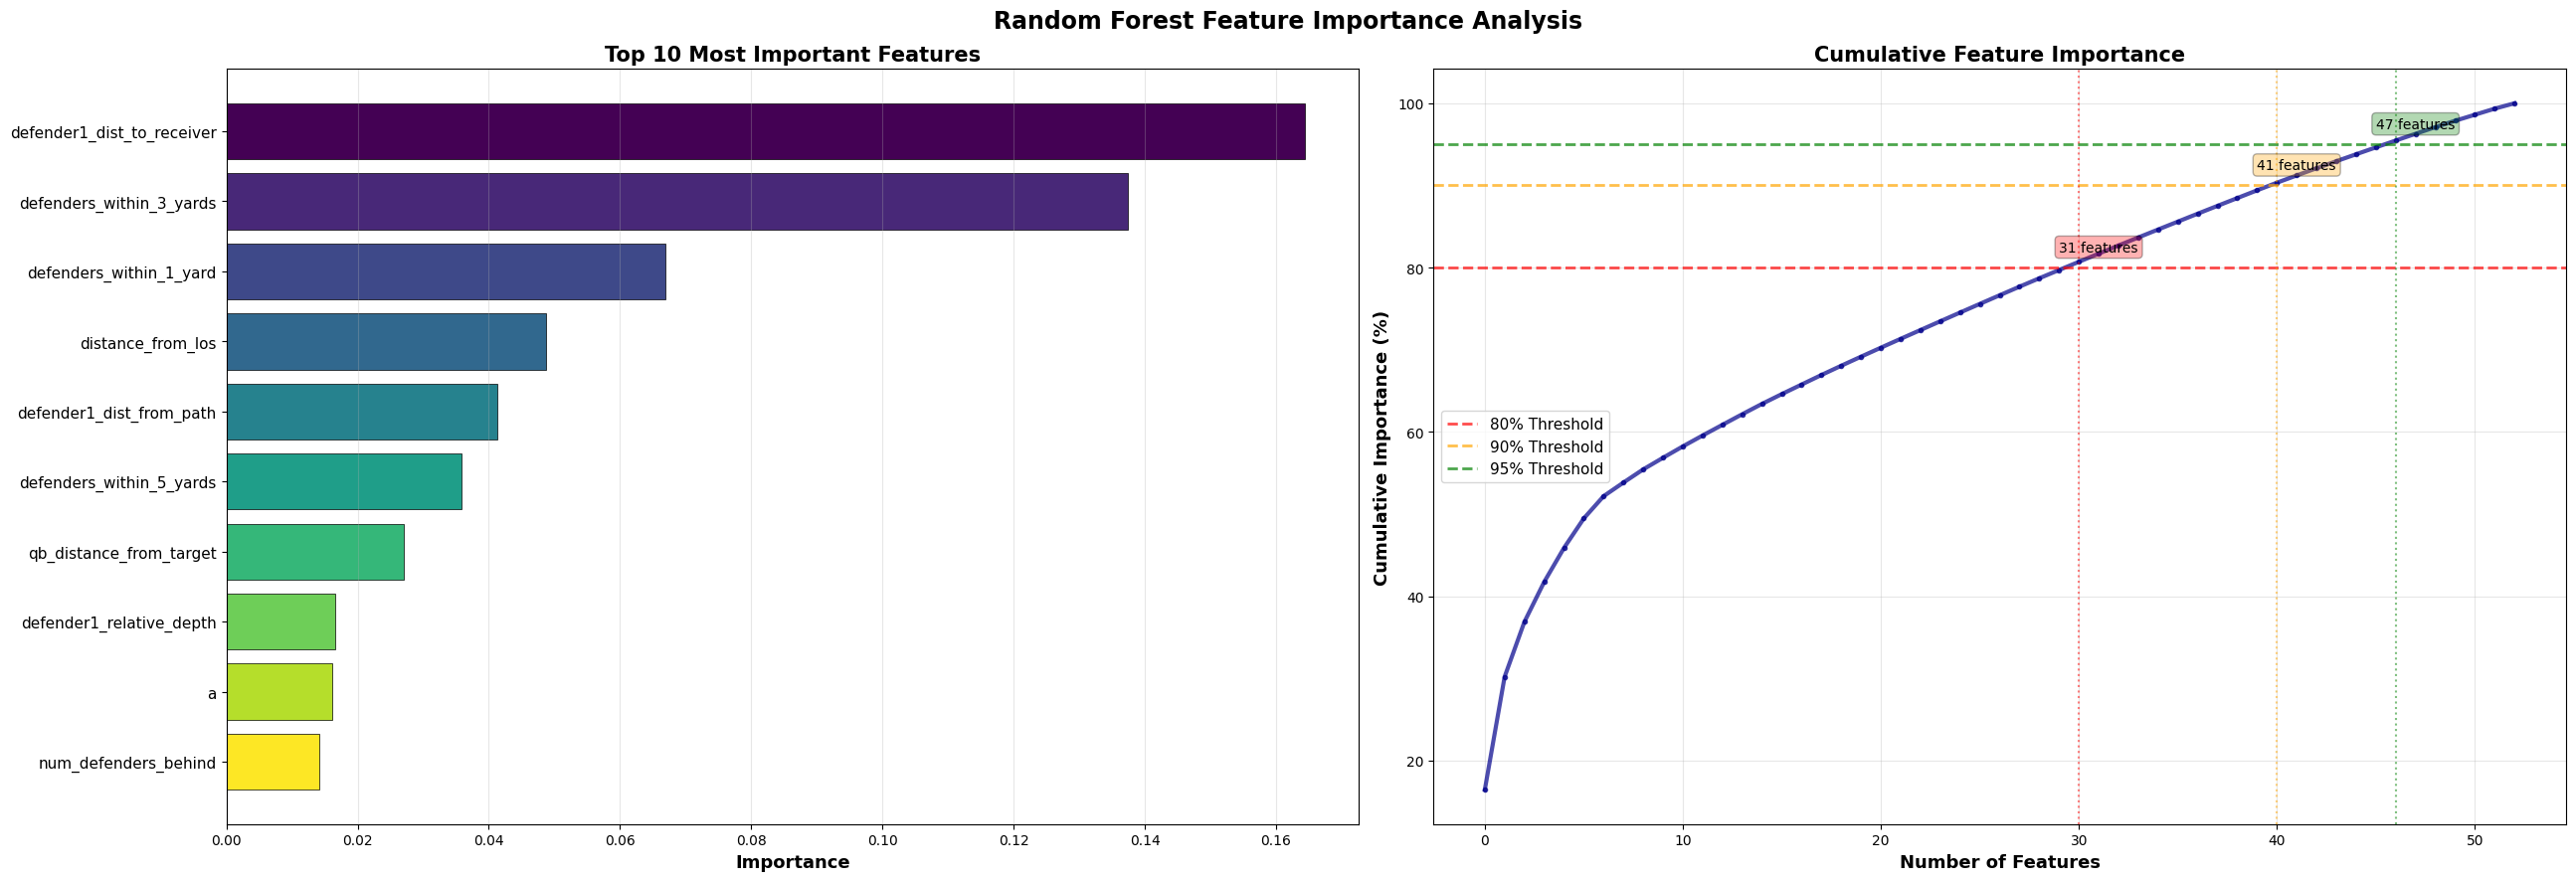


FEATURE IMPORTANCE SUMMARY

Total features: 53

Features needed to explain:
  • 80% of importance: 31 features
  • 90% of importance: 41 features
  • 95% of importance: 47 features

Top 10 Most Important Features:
                   Feature  Importance
defender1_dist_to_receiver    0.164446
  defenders_within_3_yards    0.137445
   defenders_within_1_yard    0.066920
         distance_from_los    0.048666
  defender1_dist_from_path    0.041345
  defenders_within_5_yards    0.035874
   qb_distance_from_target    0.027083
  defender1_relative_depth    0.016523
                         a    0.016078
      num_defenders_behind    0.014126

Bottom 10 Least Important Features:
                      Feature  Importance
            lagged_receiver_x    0.008578
       distance_from_sideline    0.008461
defender3_horizontal_leverage    0.008383
defender1_horizontal_leverage    0.008320
                   receiver_x    0.008184
     defender2_dist_from_path    0.008155
            lagged_receiv

In [33]:


#Create feature importance visualization with WIDER figure
fig, axes = plt.subplots(1, 2, figsize=(26, 9))  #Changed from (18, 10) to (26, 9)

#####################################################################
#Plot 1: Top 20 Features - Horizontal Bar Chart
#####################################################################

ax1 = axes[0]

top_n = 10
top_features = feat_imp.head(top_n)

#Create color gradient
colors = plt.cm.viridis(np.linspace(0, 1, len(top_features)))

bars = ax1.barh(range(len(top_features)), top_features['Importance'],
                color=colors, edgecolor='black', linewidth=0.5)

ax1.set_yticks(range(len(top_features)))
ax1.set_yticklabels(top_features['Feature'], fontsize=11)  #Slightly larger
ax1.set_xlabel('Importance', fontsize=13, fontweight='bold')
ax1.set_title(f'Top {top_n} Most Important Features', fontsize=15, fontweight='bold')
ax1.invert_yaxis()
ax1.grid(alpha=0.3, axis='x')

#REMOVED: Value labels on bars
#for i, (idx, row) in enumerate(top_features.iterrows()):
#    ax1.text(row['importance'], i, f" {row['importance']:.4f}",
#            va='center', fontsize=9, fontweight='bold')

#####################################################################
#Plot 2: Cumulative Importance
#####################################################################
ax2 = axes[1]

#Calculate cumulative importance
feature_importance_sorted = feat_imp.sort_values('Importance', ascending=False).copy()
feature_importance_sorted['cumulative_importance'] = feature_importance_sorted['Importance'].cumsum()

#Plot cumulative importance
ax2.plot(range(len(feature_importance_sorted)),
         feature_importance_sorted['cumulative_importance'] * 100,
         linewidth=3, color='darkblue', marker='o', markersize=3, alpha=0.7)

#Add reference lines
ax2.axhline(80, color='red', linestyle='--', linewidth=2, alpha=0.7, label='80% Threshold')
ax2.axhline(90, color='orange', linestyle='--', linewidth=2, alpha=0.7, label='90% Threshold')
ax2.axhline(95, color='green', linestyle='--', linewidth=2, alpha=0.7, label='95% Threshold')

#Find how many features needed for 80%, 90%, 95%
features_80 = (feature_importance_sorted['cumulative_importance'] >= 0.80).idxmax()
features_90 = (feature_importance_sorted['cumulative_importance'] >= 0.90).idxmax()
features_95 = (feature_importance_sorted['cumulative_importance'] >= 0.95).idxmax()

n_80 = feature_importance_sorted.index.get_loc(features_80) + 1
n_90 = feature_importance_sorted.index.get_loc(features_90) + 1
n_95 = feature_importance_sorted.index.get_loc(features_95) + 1

ax2.axvline(n_80 - 1, color='red', linestyle=':', linewidth=1.5, alpha=0.5)
ax2.axvline(n_90 - 1, color='orange', linestyle=':', linewidth=1.5, alpha=0.5)
ax2.axvline(n_95 - 1, color='green', linestyle=':', linewidth=1.5, alpha=0.5)

ax2.set_xlabel('Number of Features', fontsize=13, fontweight='bold')
ax2.set_ylabel('Cumulative Importance (%)', fontsize=13, fontweight='bold')
ax2.set_title('Cumulative Feature Importance', fontsize=15, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(alpha=0.3)

#Add annotations
ax2.text(n_80, 82, f'{n_80} features', fontsize=10, ha='center',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='red', alpha=0.3))
ax2.text(n_90, 92, f'{n_90} features', fontsize=10, ha='center',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='orange', alpha=0.3))
ax2.text(n_95, 97, f'{n_95} features', fontsize=10, ha='center',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='green', alpha=0.3))

plt.suptitle('Random Forest Feature Importance Analysis',
            fontsize=17, fontweight='bold', y=0.98)

plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')  #Save figure
plt.show()

#Print summary statistics
print("\n" + "="*70)
print("FEATURE IMPORTANCE SUMMARY")
print("="*70)

print(f"\nTotal features: {len(feature_importance_sorted)}")
print(f"\nFeatures needed to explain:")
print(f"  • 80% of importance: {n_80} features")
print(f"  • 90% of importance: {n_90} features")
print(f"  • 95% of importance: {n_95} features")

print(f"\nTop 10 Most Important Features:")
print(feat_imp.head(10).to_string(index=False))

print(f"\nBottom 10 Least Important Features:")
print(feat_imp.tail(10).to_string(index=False))

#Feature importance by category
print("\n" + "="*70)
print("FEATURE IMPORTANCE BY CATEGORY")
print("="*70)

#Categorize features
defender_features = [f for f in feature_cols_cp if 'defender' in f.lower()]
position_features = [f for f in feature_cols_cp if any(x in f for x in ['_x', '_y', 'distance', 'yardline'])]
qb_features = [f for f in feature_cols_cp if 'qb' in f.lower()]


The model is pretty successful, with 93% accuracy. The completion/incompletion split is comparable, so there is no class imbalance. The most important variables are  nearest defender information and some of the receiver's initial statistics. Surprisingly enough, the player's current coordinates do not matter as much.

Now, let's run a calibration plot to effectively model our results.

Mean predicted probability: 0.6258
Actual completion rate:   0.6253


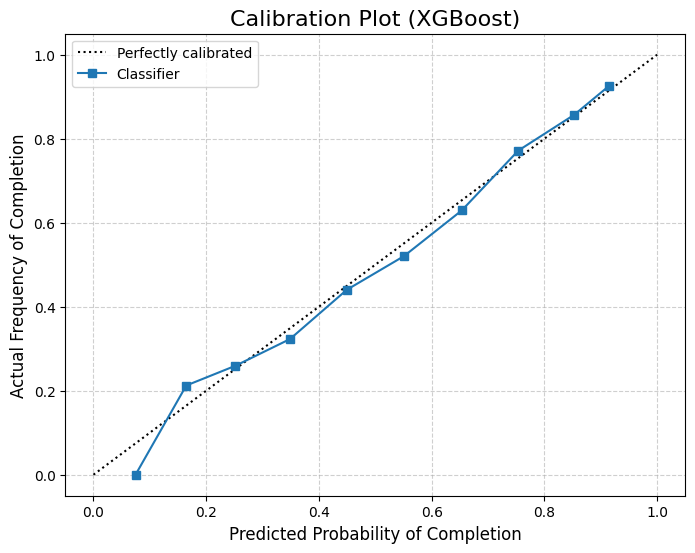

In [34]:
#Get probabilities for the "Complete" class (class 1)
#This is the raw probability, e.g., 0.75, 0.32, etc.
prob_complete = xgb_model.predict_proba(X_test)[:, 1]

print(f"Mean predicted probability: {prob_complete.mean():.4f}")
print(f"Actual completion rate:   {y_test.mean():.4f}")

#--- Generate the plot ---

#Create the figure
fig, ax = plt.subplots(figsize=(8, 6))

#Plot the "perfect" calibration line (a 45-degree dashed line)
ax.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

#Plot the model's calibration curve
#This uses the 'CalibrationDisplay' which is the modern, easy way

display = CalibrationDisplay.from_predictions(
    y_test,
    prob_complete,
    n_bins=10,
    strategy='uniform',
    ax=ax
)


#Set titles and labels
ax.set_title("Calibration Plot (XGBoost)", fontsize=16)
ax.set_xlabel("Predicted Probability of Completion", fontsize=12)
ax.set_ylabel("Actual Frequency of Completion", fontsize=12)
ax.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Now that we are satisfied with the results, let's fit the model onto the entire dataset and conduct some post-modeling data analysis.

In [35]:
#Generate predictions on entire dataset using existing trained model

print("=" * 70)
print("GENERATING PREDICTIONS ON ENTIRE DATASET")
print("=" * 70)

#Prepare the full dataset the same way as training data
X_full = final_cleaned_output.copy()


#Select features
X_full = X_full[feature_cols_cp]

#Handle missing values
for col in X_full.columns:
    if X_full[col].isna().any():
        X_full[col].fillna(X_full[col].median(), inplace=True)

print(f"Generating predictions for {len(X_full):,} frames...")

#Use the EXISTING trained model to predict
y_pred_full = xgb_model.predict(X_full)
y_pred_proba_full = xgb_model.predict_proba(X_full)[:, 1]

#Add predictions to the dataframe
final_cleaned_output['predicted_catch_prob'] = y_pred_proba_full
final_cleaned_output['predicted_catch'] = y_pred_full

print(f"\n✓ Predictions added to final_cleaned_output")
print(f"  • Column 'predicted_catch_prob': Probability of catch")
print(f"  • Column 'predicted_catch': Binary prediction (0/1)")

#Create full dataset version for analysis
final_data = final_cleaned_output.copy()

print("\n✓ test_data_full created (entire dataset with predictions)")
print("=" * 70)

GENERATING PREDICTIONS ON ENTIRE DATASET
Generating predictions for 160,263 frames...

✓ Predictions added to final_cleaned_output
  • Column 'predicted_catch_prob': Probability of catch
  • Column 'predicted_catch': Binary prediction (0/1)

✓ test_data_full created (entire dataset with predictions)


In [36]:
final_cleaned_output

,game_id,play_id,nfl_id,frame_id,x,y,nfl_id_target,receiver_x,receiver_y,dist_to_receiver,defender1_dist_to_receiver,defender2_dist_to_receiver,defender3_dist_to_receiver,defender4_dist_to_receiver,defender5_dist_to_receiver,defender1_nfl_id,defender2_nfl_id,defender3_nfl_id,defender4_nfl_id,defender5_nfl_id,defender1_x,defender2_x,defender3_x,defender4_x,defender5_x,defender1_y,defender2_y,defender3_y,defender4_y,defender5_y,defenders_within_1_yard,defenders_within_3_yards,defenders_within_5_yards,play_direction,absolute_yardline_number,player_name,player_position,x_meta,y_meta,s,a,dir,o,ball_land_x,ball_land_y,qb_release_x,qb_release_y,qb_release_a,qb_release_s,qb_release_dir,qb_release_o,qb_distance_from_sideline,num_defenders_within_2_yards_qb,num_defenders_within_5_yards_qb,num_players_within_5_yards_qb,initial_receiver_x,initial_receiver_y,lagged_receiver_x,lagged_receiver_y,lagged2_receiver_x,lagged2_receiver_y,defender1_relative_depth,defender1_dist_from_path,defender2_relative_depth,defender2_dist_from_path,defender3_relative_depth,defender3_dist_from_path,defender4_relative_depth,defender4_dist_from_path,defender5_relative_depth,defender5_dist_from_path,num_defenders_in_front,num_defenders_behind,num_defenders_in_passing_lane,defender1_horizontal_leverage,defender2_horizontal_leverage,defender3_horizontal_leverage,defender4_horizontal_leverage,defender5_horizontal_leverage,time_in_air,distance_from_sideline,distance_from_los,qb_distance_from_target,quarter,down,yards_to_go,offense_formation,receiver_alignment,play_action,dropback_distance,defenders_in_the_box,team_coverage_man_zone,team_coverage_type,pass_result,expected_points_added,play_description,pre_penalty_yards_gained,pass_length,is_complete,predicted_catch_prob,predicted_catch
0,2023090700,101,44930,1,53.20,13.98,44930,53.20,13.98,0.0,4.473299,5.579176,99.000000,99.0,99.0,46137.0,52546.0,-1.0,-1.0,-1.0,56.22,47.94,-999.00,-999.0,-999.0,17.28,12.12,-999.00,-999.0,-999.0,0.0,0.0,1.0,right,42,Josh Reynolds,WR,52.43,14.14,7.90,2.68,99.25,106.80,63.259998,-0.22,35.41,29.99,0.47,0.64,108.83,212.25,23.31,0.0,0.0,0.0,53.20,13.98,53.20,13.98,53.20,13.98,0.037304,4.473143,-2.665605,4.901199,99.000000,99.000000,99.0,99.0,99.0,99.0,1,1,0,4.473143,-4.901199,99.000000,99.0,99.0,0.0,13.98,11.20,23.933328,1,3,3,SHOTGUN,2x2,False,2.13,6,ZONE_COVERAGE,COVER_2_ZONE,I,-2.145443,(14:25) (Shotgun) J.Goff pass incomplete deep right to J.Reynolds.,0,22,0,0.462650,0
1,2023090700,101,44930,2,53.96,13.78,44930,53.96,13.78,0.0,4.091320,6.428911,99.000000,99.0,99.0,46137.0,52546.0,-1.0,-1.0,-1.0,56.63,47.86,-999.00,-999.0,-999.0,16.88,11.75,-999.00,-999.0,-999.0,0.0,0.0,1.0,right,42,Josh Reynolds,WR,52.43,14.14,7.90,2.68,99.25,106.80,63.259998,-0.22,35.41,29.99,0.47,0.64,108.83,212.25,23.31,0.0,0.0,0.0,53.20,13.98,53.20,13.98,53.20,13.98,-0.029329,4.091215,-3.257552,5.542495,99.000000,99.000000,99.0,99.0,99.0,99.0,2,0,0,4.091215,-5.542495,99.000000,99.0,99.0,0.1,13.78,11.96,24.634663,1,3,3,SHOTGUN,2x2,False,2.13,6,ZONE_COVERAGE,COVER_2_ZONE,I,-2.145443,(14:25) (Shotgun) J.Goff pass incomplete deep right to J.Reynolds.,0,22,0,0.470525,0
2,2023090700,101,44930,3,54.70,13.54,44930,54.70,13.54,0.0,3.754464,7.258271,99.000000,99.0,99.0,46137.0,52546.0,-1.0,-1.0,-1.0,57.06,47.78,-999.00,-999.0,-999.0,16.46,11.35,-999.00,-999.0,-999.0,0.0,0.0,1.0,right,42,Josh Reynolds,WR,52.43,14.14,7.90,2.68,99.25,106.80,63.259998,-0.22,35.41,29.99,0.47,0.64,108.83,212.25,23.31,0.0,0.0,0.0,53.20,13.98,53.96,13.78,53.20,13.98,-0.098992,3.753159,-3.844376,6.156564,99.000000,99.000000,99.0,99.0,99.0,99.0,2,0,0,3.753159,-6.156564,99.000000,99.0,99.0,0.2,13.54,12.70,25.351659,1,3,3,SHOTGUN,2x2,False,2.13,6,ZONE_COVERAGE,COVER_2_ZONE,I,-2.145443,(14:25) (Shotgun) J.Goff pass incomplete deep right to J.Reynolds.,0,22,0,0.473704,0
3,2023090700,101,44930,4,55.41,13.27,44930,55.41,13.27,0.0,3.442005,8.043985,99.000000,99.0,99.0,46137.0,52546.0,-1.0,-1.0,-1.0,57.48,47.72,-999.00,-999.0,-999.0,16.02,10.91,-999.00,-999.0,

# Yards After Catch model

The next step is creating a "yards after catch" model. We are able to get this by subtracting the pass length from the total yards gained. We also need to filter for only completions.

In [37]:
final_cleaned_output["yards_after_catch"] = final_cleaned_output["pre_penalty_yards_gained"] - final_cleaned_output["pass_length"]

Fumbles are also pretty annoying to deal with because the yards gained is the net yards gained. Let's remove that.

## Model

Features we want:
- Receiver position (x,y)
- Initial positioning, speed, orientation, acceleration, and direction
- Nearest defender and second nearest defender info
- Defenders within 2, 5, and 10 yards
- Time in air
- Distance from LOS
- Distance from sideline
- Lagged information
- Dropback distance, yards to go, defenders in box
- QB information
- Down, quarter, team coverage type, man or zone

Build out YACOE specific feats

In [38]:
def get_orientation_penalty(row):
    # Calculate absolute difference from 0 (ideal facing)
    # We take min(diff, 360-diff) to handle the 0/360 wrap-around
    angle = row['o']
    diff = min(abs(angle - 0), abs(angle - 360))
    return diff

# 0 = Perfect (Facing Endzone), 180 = Terrible (Facing QB)
final_cleaned_output['orientation_penalty'] = final_cleaned_output.apply(get_orientation_penalty, axis=1)

In [39]:
# Create a binary or continuous penalty for running out of bounds
# Assuming Y=0 and Y=53.3 are the sidelines

def get_sideline_danger(row):
    y = row['receiver_y']
    angle_rad = np.radians(90 - row['dir']) # Convert to math angle
    v_y = np.sin(angle_rad) # Vertical velocity component (towards sideline)

    # If he is close to top sideline (y > 45) AND moving up (v_y > 0)
    if y > 45 and v_y > 0:
        return 1
    # If he is close to bottom sideline (y < 8) AND moving down (v_y < 0)
    elif y < 8 and v_y < 0:
        return 1
    return 0

final_cleaned_output['sideline_danger'] = final_cleaned_output.apply(get_sideline_danger, axis=1)

In [40]:
def count_defenders_ahead(row):
    rx = row['receiver_x']
    count = 0
    # Loop through your defender columns (you need the raw X coords for this)
    # This assumes you have defender1_x ... defender11_x available
    # or you iterate through the raw tracking frame if you haven't flattened it yet.

    # Example for flattened Top 5 defenders:
    for i in range(1, 6):
        d_x = row.get(f'defender{i}_x', -999) # Use get to avoid errors
        if d_x > rx: # Defender is closer to endzone than receiver
            count += 1
    return count

final_cleaned_output['defenders_ahead'] = final_cleaned_output.apply(count_defenders_ahead, axis=1)

In [41]:
def calculate_dist_to_goal(row):
    # Check play direction to decide which goal line to aim for
    # Adjust 'right'/'left' strings if your data uses 'right'/'left' vs other labels

    if row['play_direction'] == 'right':
        # Moving towards x=120. Goal line is at x=110.
        return 110 - row['receiver_x']
    else:
        # Moving towards x=0. Goal line is at x=10.
        return row['receiver_x'] - 10

# Apply the function
# Ensure 'play_direction' is in your dataframe before running!
final_cleaned_output['receiver_dist_to_goal'] = final_cleaned_output.apply(calculate_dist_to_goal, axis=1)

In [42]:
def calculate_downfield_velocity(row):
    # Convert direction to radians (NFL tracking data is 0-360, 0=Y axis, clockwise)
    # Standard math conversion:
    theta_rad = np.radians(90 - row['dir'])

    # Calculate Velocity X (Movement along the field length)
    # Positive = Moving towards x=100 (or 110)
    # Negative = Moving towards x=0
    v_x = row['s'] * np.cos(theta_rad)

    # If play is going Right (to 110), positive v_x is good.
    # If play is going Left (to 0), negative v_x is good.
    if row['play_direction'] == 'left':
        return -v_x
    else:
        return v_x

final_cleaned_output['downfield_velocity'] = final_cleaned_output.apply(calculate_downfield_velocity, axis=1)

In [43]:
# Measure the isolation of the engagement
final_cleaned_output['defender_isolation_gap'] = (
    final_cleaned_output['defender2_dist_to_receiver'] - final_cleaned_output['defender1_dist_to_receiver']
)

In [44]:
import math

def calculate_open_space_cone(row):
    # --- 1. Setup Geometry ---
    # Cone is 170 degrees total (-85 to +85)
    # We'll cast a ray every 10 degrees
    angles_to_check = np.arange(-85, 86, 10)

    rx, ry = row['receiver_x'], row['receiver_y']

    # Get Receiver Direction in Radians (NFL 0 = North/Y-axis, Clockwise)
    # We convert to standard Math radians (0 = East/X-axis, Counter-Clockwise)
    if pd.isna(row['dir']):
        return 0
    r_dir_math = np.radians(90 - row['dir'])

    # Play Direction Adjustment
    # If play is Left-to-Right (X increases), LOS is likely behind (Negative X relative to Rec)
    # If play is Right-to-Left (X decreases), LOS is behind (Positive X relative to Rec)
    going_right = row['play_direction'] == 'right'
    los_x = row['absolute_yardline_number']
    if not going_right:
        los_x = 100 - los_x # Adjust if needed based on your coord system logic

    valid_rays_total_dist = 0
    valid_ray_count = 0

    # --- 2. Cast Rays ---
    for angle_offset in angles_to_check:
        # Calculate the absolute angle of this specific ray
        ray_angle = r_dir_math + np.radians(angle_offset)

        # Unit vector for this ray
        u_x = np.cos(ray_angle)
        u_y = np.sin(ray_angle)

        # --- CONSTRAINT A: Back towards LOS ---
        # If going right (positive X), a "backward" path has negative u_x
        if going_right and u_x < -0.1: continue # Allow slight lateral, but not backward
        if not going_right and u_x > 0.1: continue

        # --- CONSTRAINT B: Max Range (Theoretical max YAC) ---
        # We assume a max vision of 30 yards to save computation
        max_dist = 30.0

        # --- CONSTRAINT C: Sidelines (Y=0, Y=53.3) ---
        # Distance to top sideline (53.3)
        if u_y > 0: # Moving Up
            dist_sideline = (53.3 - ry) / u_y
            max_dist = min(max_dist, dist_sideline)
        elif u_y < 0: # Moving Down
            dist_sideline = (0 - ry) / u_y
            max_dist = min(max_dist, dist_sideline)

        # --- CONSTRAINT D: Defenders ---
        # We check the closest defender on this specific ray path
        # Simple projection: Is the defender within a narrow width of this ray?

        closest_def_dist = max_dist # Start with the boundary max

        # Loop through top 5 defenders (assuming you have flattened columns)
        # If you haven't flattened, you'd need to access the list of defenders
        for i in range(1, 6):
            try:
                dx = row[f'nearest_defender_x'] if i==1 else row[f'defender{i}_x']
                dy = row[f'nearest_defender_y'] if i==1 else row[f'defender{i}_y']
            except KeyError:
                continue

            # Vector to defender
            vec_x = dx - rx
            vec_y = dy - ry
            dist_to_def = np.sqrt(vec_x**2 + vec_y**2)

            # Project defender onto the ray
            # Dot product to find distance along the ray
            dot_prod = (vec_x * u_x) + (vec_y * u_y)

            # Rejection: How far "off" the ray is the defender?
            # Rejection^2 = Dist^2 - Projection^2
            if dot_prod > 0: # Defender is in front
                rejection_sq = dist_to_def**2 - dot_prod**2

                # If defender is within 1.5 yards of the ray line, they block it
                if rejection_sq < (1.5**2):
                    closest_def_dist = min(closest_def_dist, dot_prod)

        # Add the valid distance of this ray to the total
        valid_rays_total_dist += closest_def_dist
        valid_ray_count += 1

    # --- 3. Aggregate ---
    if valid_ray_count == 0:
        return 0

    # Returns average "open yards" available in the cone
    return valid_rays_total_dist / valid_ray_count

# --- APPLY ---
# Note: This is computationally expensive! Test on a small sample first.
print("Calculating Open Space Cone...")
# df_sample = final_cleaned_output.head(100).copy() # Use this to test for errors first
final_cleaned_output['cone_open_space'] = final_cleaned_output.apply(calculate_open_space_cone, axis=1)

Calculating Open Space Cone...


In [45]:
#Subsetting the data to only include completions and removing fumbles cause they mess with the net yards
final_completed = final_cleaned_output[final_cleaned_output["pass_result"] == "C"]
final_completed = final_completed[~final_completed["play_description"].str.contains("FUMBLES", case=False, na=False)]

#Defining independent and dependent variables
numeric_features2 = [

    # Context
    'absolute_yardline_number', 'distance_from_los', 'distance_from_sideline',
    'yards_to_go', 'defenders_in_the_box', 'dropback_distance',

    # Receiver Info
    's', 'a', 'dir', 'o',

    # Defender Structure
    'num_defenders_behind',
    'defenders_within_1_yard', 'defenders_within_3_yards', 'defenders_within_5_yards',

    #YACOE Specific
    'defenders_ahead', 'sideline_danger', 'orientation_penalty', 'receiver_dist_to_goal', 'downfield_velocity',
    'defender_isolation_gap', 'cone_open_space'

]
# Add Top 5 Defender Metrics
for i in range(1, 6):
    numeric_features2.extend([
        f'defender{i}_dist_to_receiver',
        f'defender{i}_relative_depth',
        f'defender{i}_horizontal_leverage',
    ])

categorical_features2 = ['team_coverage_man_zone', 'team_coverage_type']

X = final_completed.copy()

label_encoders = {}

for col in categorical_features2:
    le = LabelEncoder()
    X[col] = X[col].astype(str)
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le

feature_cols_yac = numeric_features2 + categorical_features2
X = X[feature_cols_yac]
y = final_completed["yards_after_catch"]

#Handling missing values
print(f"\nMissing values before imputation:")
missing_counts = X.isna().sum()
print(missing_counts[missing_counts > 0])

for col in X.columns:
    if X[col].isna().any():
        X[col].fillna(X[col].median(), inplace=True)

#Train/test split and stratify by plays rather than by frames - Let's get the plays and split them first
plays = final_completed[['game_id', 'play_id']].drop_duplicates()

train_plays, test_plays = train_test_split(
    plays,
    test_size=0.2,
    random_state=42,
)

#Now we create train and test dataframes based on the plays
# Get original row indices for train plays
train_idx = (
    final_cleaned_output
    .reset_index()  # original index becomes a column named 'index'
    .merge(train_plays, on=['game_id', 'play_id'], how='inner')['index']
)

# Same for test
test_idx = (
    final_cleaned_output
    .reset_index()
    .merge(test_plays, on=['game_id', 'play_id'], how='inner')['index']
)

# Now safely index X and y
X_train, X_test = X.loc[train_idx], X.loc[test_idx]
y_train, y_test = y.loc[train_idx], y.loc[test_idx]



Missing values before imputation:
Series([], dtype: int64)


Now to train the Model (XGBoost)

In [46]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

print("Training XGBoost Regressor...")

xgb_model_yac = XGBRegressor(
    n_estimators=1000,        # XGB benefits from more trees + lower learning rate
    learning_rate=0.025,      # "Slow" learning allows it to find subtle patterns
    max_depth=4,             # Keep this low (4-6) for tracking data to prevent overfitting
    min_child_weight=20,     # Similar to min_samples_leaf in RF
    subsample=0.7,           # Use 80% of rows per tree
    colsample_bytree=0.7,    # Use 80% of columns per tree
    objective='reg:squarederror',
    n_jobs=-1,
    early_stopping_rounds=50,
    random_state=42
)

# Fit with Early Stopping
# This stops training if the validation error stops improving for 50 rounds
xgb_model_yac.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=100
)

# Step 7: Predictions
y_pred = xgb_model_yac.predict(X_test)

# Evaluation Metrics
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nRMSE: {rmse:.4f} (Average error in yards)")
print(f"\nMAE: {mae:.4f}")
print(f"R2 Score: {r2:.4f}")

feature_importance = pd.DataFrame({
    'feature': feature_cols_yac,
    'importance': xgb_model_yac.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance.to_string(index=False))

# Add predictions back to test data for analysis
test_data_yac = final_completed.loc[test_idx].copy()
test_data_yac['predicted_yac'] = y_pred
test_data_yac['yac_error'] = test_data_yac['yards_after_catch'] - test_data_yac['predicted_yac']

test_data_yac.head()

Training XGBoost Regressor...
[0]	validation_0-rmse:6.75230
[100]	validation_0-rmse:5.99297
[200]	validation_0-rmse:5.90324
[300]	validation_0-rmse:5.89721
[332]	validation_0-rmse:5.90078

RMSE: 5.8949 (Average error in yards)

MAE: 3.5464
R2 Score: 0.2434
                      feature  importance
     defenders_within_5_yards    0.134223
         num_defenders_behind    0.079412
   defender1_dist_to_receiver    0.069328
     defender1_relative_depth    0.045186
        receiver_dist_to_goal    0.032346
       defender_isolation_gap    0.030050
   defender5_dist_to_receiver    0.029639
              cone_open_space    0.026997
defender1_horizontal_leverage    0.026919
                            a    0.026512
       distance_from_sideline    0.026355
   defender2_dist_to_receiver    0.026286
     defender2_relative_depth    0.025246
defender4_horizontal_leverage    0.024377
       team_coverage_man_zone    0.024357
     absolute_yardline_number    0.024118
              sideline_danger

,game_id,play_id,nfl_id,frame_id,x,y,nfl_id_target,receiver_x,receiver_y,dist_to_receiver,defender1_dist_to_receiver,defender2_dist_to_receiver,defender3_dist_to_receiver,defender4_dist_to_receiver,defender5_dist_to_receiver,defender1_nfl_id,defender2_nfl_id,defender3_nfl_id,defender4_nfl_id,defender5_nfl_id,defender1_x,defender2_x,defender3_x,defender4_x,defender5_x,defender1_y,defender2_y,defender3_y,defender4_y,defender5_y,defenders_within_1_yard,defenders_within_3_yards,defenders_within_5_yards,play_direction,absolute_yardline_number,player_name,player_position,x_meta,y_meta,s,a,dir,o,ball_land_x,ball_land_y,qb_release_x,qb_release_y,qb_release_a,qb_release_s,qb_release_dir,qb_release_o,qb_distance_from_sideline,num_defenders_within_2_yards_qb,num_defenders_within_5_yards_qb,num_players_within_5_yards_qb,initial_receiver_x,initial_receiver_y,lagged_receiver_x,lagged_receiver_y,lagged2_receiver_x,lagged2_receiver_y,defender1_relative_depth,defender1_dist_from_path,defender2_relative_depth,defender2_dist_from_path,defender3_relative_depth,defender3_dist_from_path,defender4_relative_depth,defender4_dist_from_path,defender5_relative_depth,defender5_dist_from_path,num_defenders_in_front,num_defenders_behind,num_defenders_in_passing_lane,defender1_horizontal_leverage,defender2_horizontal_leverage,defender3_horizontal_leverage,defender4_horizontal_leverage,defender5_horizontal_leverage,time_in_air,distance_from_sideline,distance_from_los,qb_distance_from_target,quarter,down,yards_to_go,offense_formation,receiver_alignment,play_action,dropback_distance,defenders_in_the_box,team_coverage_man_zone,team_coverage_type,pass_result,expected_points_added,play_description,pre_penalty_yards_gained,pass_length,is_complete,predicted_catch_prob,predicted_catch,yards_after_catch,orientation_penalty,sideline_danger,defenders_ahead,receiver_dist_to_goal,downfield_velocity,defender_isolation_gap,cone_open_space,predicted_yac,yac_error
21,2023090700,194,41325,1,88.43,21.99,41325,88.43,21.99,0.0,1.935459,9.398649,12.305743,12.703204,99.0,54653.0,44888.0,53953.0,55910.0,-1.0,90.31,85.38,76.70,77.26,-999.0,22.45,30.88,18.27,28.04,-999.0,0.0,1.0,1.0,left,89,Jerick McKinnon,RB,88.98,22.23,6.09,2.14,245.74,314.63,84.940002,21.75,97.62,29.67,1.64,0.96,185.14,285.7,23.63,0.0,0.0,0.0,88.43,21.99,88.43,21.99,88.43,21.99,-1.737558,0.852581,-3.360366,8.777388,11.386246,4.667409,4.691514,11.805130,99.0,99.0,2,2,1,0.852581,-8.777388,-4.667409,-11.805130,99.0,0.0,21.99,0.57,11.976581,1,3,2,SHOTGUN,2x2,False,3.86,6,MAN_COVERAGE,COVER_1_MAN,C,1.702563,(12:56) (Shotgun) P.Mahomes pass short left to J.McKinnon to KC 31 for 10 yards (M.Rodriguez).,10,6,1,0.696538,1,4,45.37,0,1,78.43,5.552194,7.463190,26.093051,9.618674,-5.618674
22,2023090700,194,41325,2,87.88,21.76,41325,87.88,21.76,0.0,1.953510,9.075423,12.001671,12.834532,99.0,54653.0,44888.0,53953.0,55910.0,-1.0,89.79,85.40,76.37,77.02,-999.0,22.17,30.49,18.36,28.60,-999.0,0.0,1.0,1.0,left,89,Jerick McKinnon,RB,88.98,22.23,6.09,2.14,245.74,314.63,84.940002,21.75,97.62,29.67,1.64,0.96,185.14,285.7,23.63,0.0,0.0,0.0,88.43,21.99,88.43,21.99,88.43,21.99,-1.741126,0.885821,-3.578376,8.340175,11.078158,4.616764,4.118164,12.155901,99.0,99.0,2,2,1,0.885821,-8.340175,-4.616764,-12.155901,99.0,0.1,21.76,1.12,12.547338,1,3,2,SHOTGUN,2x2,False,3.86,6,MAN_COVERAGE,COVER_1_MAN,C,1.702563,(12:56) (Shotgun) P.Mahomes pass short left to J.McKinnon to KC 31 for 10 yards (M.Rodriguez).,10,6,1,0.678997,1,4,45.37,0,1,77.88,5.552194,7.121913,26.001983,8.759656,-4.759656
23,2023090700,194,41325,3,87.33,21.56,41325,87.33,21.56,0.0,1.933805,8.706607,11.655355,12.972220,99.0,54653.0,44888.0,53953.0,55910.0,-1.0,89.23,85.40,76.10,76.81,-999.0,21.92,30.05,18.44,29.15,-999.0,0.0,1.0,1.0,left,89,Jerick McKinnon,RB,88.98,22.23,6.09,2.14,245.74,314.63,84.940002,21.75,97.62,29.67,1.64,0.96,185.14,285.7,23.63,0.0,0.0,0.0,88.43,21.99,87.88,21.76,88.43,21.99,-1.715082,0.893361,-3.739512,7.862636,10.751217,4.500959,3.564093,12.473001,99.0,99.0,2,2,1

In [47]:
test_data_yac["residual"] = test_data_yac["yards_after_catch"] - test_data_yac["predicted_yac"]

In [48]:
test_data_yac["predicted_yac"].describe()

,predicted_yac
count,19813.000000
mean,4.527600
std,2.938899
min,-1.604504
25%,2.485439
50%,3.921470
75%,6.225156
max,24.189846


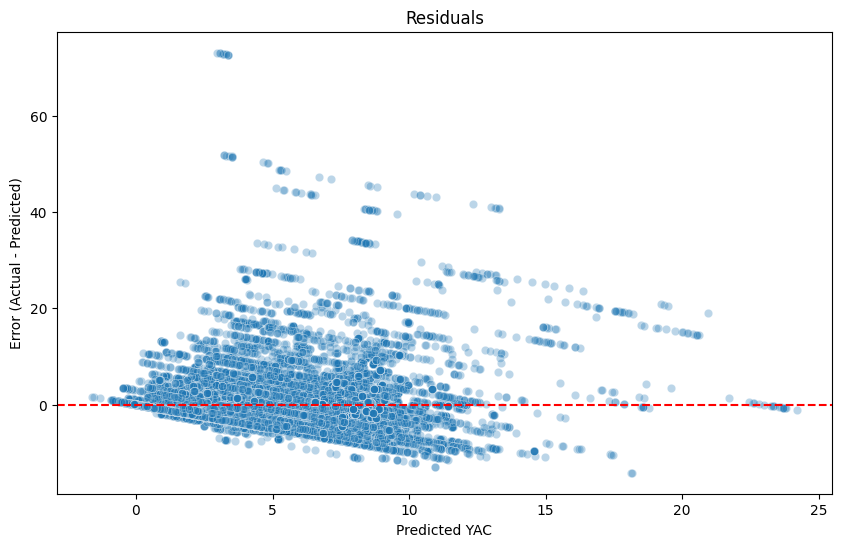

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate residuals
test_data_yac = final_completed.loc[test_idx].copy()
test_data_yac['predicted_yac'] = xgb_model_yac.predict(X_test)
test_data_yac['residual'] = test_data_yac['yards_after_catch'] - test_data_yac['predicted_yac']

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='predicted_yac', y='residual', data=test_data_yac, alpha=0.3)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Predicted YAC')
plt.ylabel('Error (Actual - Predicted)')
plt.title('Residuals')
plt.show()

# Applications

In [50]:
# Convert to category dtype
final_cleaned_output["team_coverage_man_zone"] = final_cleaned_output["team_coverage_man_zone"].astype("category")
final_cleaned_output["team_coverage_type"] = final_cleaned_output["team_coverage_type"].astype("category")

X_full = final_cleaned_output[feature_cols_yac]
final_cleaned_output["predicted_yac"] = xgb_model_yac.predict(X_full)


In [51]:
final_cleaned_output["yards_after_catch"] = np.where(final_cleaned_output["pass_result"] != "C", 0, final_cleaned_output["yards_after_catch"])

In [52]:
preds = xgb_model_yac.predict(X_full)

print("Prediction summary:")
print(pd.Series(preds).describe())

# No NaNs or infs
assert not np.isnan(preds).any()
assert np.isfinite(preds).all()


Prediction summary:
count    160263.000000
mean          4.219889
std           2.888571
min          -1.956194
25%           2.239597
50%           3.728141
75%           5.727731
max          35.105400
dtype: float64


In [53]:
final_cleaned_output["value_score"] = final_cleaned_output["predicted_catch_prob"]*(final_cleaned_output["pass_length"]+final_cleaned_output["predicted_yac"])

In [54]:
import numpy as np
import pandas as pd

GAME_ID = 2023100500   # <-- fill in
PLAY_ID = 818   # <-- fill in

slots = range(1, 6)  # defender1..defender5 (adjust if needed)

def score_cp_yac(df_rows):
    """Return p(catch) and yac predictions for 1+ rows."""
    X_cp = df_rows[feature_cols_cp]
    p = xgb_model.predict_proba(X_cp)[:, 1]

    X_yac = df_rows[feature_cols_yac]
    yac = xgb_model_yac.predict(X_yac)
    return p, yac

def defender_slot_cols(df, k):
    """All defender{k}_* columns except defender{k}_nfl_id (keep IDs unchanged)."""
    prefix = f"defender{k}_"
    cols = [c for c in df.columns if c.lower().startswith(prefix)]
    return [c for c in cols if c.lower() != f"defender{k}_nfl_id"]

def remove_defender_k(df_rows, k):
    """
    Remove defender k *only* by setting defender{k}_ geometry columns to 99.
    (Keeps all other defenders unchanged.)
    """
    out = df_rows.copy()
    k_cols = defender_slot_cols(out, k)
    if k_cols:
        out.loc[:, k_cols] = 99
    return out


In [55]:
play_df = final_cleaned_output.query("game_id == @GAME_ID and play_id == @PLAY_ID").copy()

if "frame_id" in play_df.columns:
    play_df = play_df.sort_values("frame_id").reset_index(drop=True)
else:
    play_df = play_df.reset_index(drop=True)

print("Frames in play:", len(play_df))
play_df.head()

# --- get pass_length ONCE (constant within play) ---
pass_length = play_df["pass_length"].iloc[0] if len(play_df) > 0 else np.nan

results = []

p_base, yac_base = score_cp_yac(play_df)

for idx in range(len(play_df)):
    frame_row = play_df.iloc[[idx]]
    frame_id = frame_row["frame_id"].iloc[0] if "frame_id" in frame_row.columns else idx

    # baseline row
    results.append({
        "game_id": GAME_ID,
        "play_id": PLAY_ID,
        "frame_id": frame_id,
        "pass_length": pass_length,
        "scenario": "baseline",
        "defender_slot": np.nan,
        "defender_nfl_id": np.nan,
        "p_catch": float(p_base[idx]),
        "pred_yac": float(yac_base[idx])
    })

    for k in slots:
        id_col = f"defender{k}_nfl_id"
        if id_col not in frame_row.columns:
            continue

        defender_id = frame_row[id_col].iloc[0]
        if defender_id == -1:
            break
        if pd.isna(defender_id):
            continue

        cf = remove_defender_k(frame_row, k)
        p_cf, yac_cf = score_cp_yac(cf)

        results.append({
            "game_id": GAME_ID,
            "play_id": PLAY_ID,
            "frame_id": frame_id,
            "pass_length": pass_length,
            "scenario": f"remove_defender{k}",
            "defender_slot": k,
            "defender_nfl_id": defender_id,
            "p_catch": float(p_cf[0]),
            "pred_yac": float(yac_cf[0])
        })

res_play = pd.DataFrame(results)
res_play.head(20)


Frames in play: 10


,game_id,play_id,frame_id,pass_length,scenario,defender_slot,defender_nfl_id,p_catch,pred_yac
0,2023100500,818,1,6,baseline,NaN,NaN,0.789829,4.985562
1,2023100500,818,1,6,remove_defender1,1.0,55880.0,0.891883,10.296027
2,2023100500,818,1,6,remove_defender2,2.0,52624.0,0.796640,3.780741
3,2023100500,818,2,6,baseline,NaN,NaN,0.819317,5.154260
4,2023100500,818,2,6,remove_defender1,1.0,55880.0,0.891883,10.380871
5,2023100500,818,2,6,remove_defender2,2.0,52624.0,0.825384,3.957030
6,2023100500,818,3,6,baseline,NaN,NaN,0.819317,5.395269
7,2023100500,818,3,6,remove_defender1,1.0,55880.0,0.891883,10.711450
8,2023100500,818,3,6,remove_defender2,2.0,52624.0,0.825384,4.198040
9,2023100500,818,4,6,baseline,NaN,NaN,0.834434,5.392654


In [56]:
baseline = (
    res_play[res_play["scenario"] == "baseline"]
    .loc[:, ["frame_id", "p_catch", "pred_yac"]]
    .rename(columns={"p_catch": "p_base", "pred_yac": "yac_base"})
)

res_play = res_play.merge(baseline, on="frame_id", how="left")
res_play["delta_p_catch"] = res_play["p_catch"] - res_play["p_base"]
res_play["delta_yac"] = res_play["pred_yac"] - res_play["yac_base"]

# show only counterfactual rows
res_play[res_play["scenario"] != "baseline"].head(20)


,game_id,play_id,frame_id,pass_length,scenario,defender_slot,defender_nfl_id,p_catch,pred_yac,p_base,yac_base,delta_p_catch,delta_yac
1,2023100500,818,1,6,remove_defender1,1.0,55880.0,0.891883,10.296027,0.789829,4.985562,0.102054,5.310465
2,2023100500,818,1,6,remove_defender2,2.0,52624.0,0.796640,3.780741,0.789829,4.985562,0.006811,-1.204821
4,2023100500,818,2,6,remove_defender1,1.0,55880.0,0.891883,10.380871,0.819317,5.154260,0.072566,5.226611
5,2023100500,818,2,6,remove_defender2,2.0,52624.0,0.825384,3.957030,0.819317,5.154260,0.006066,-1.197230
7,2023100500,818,3,6,remove_defender1,1.0,55880.0,0.891883,10.711450,0.819317,5.395269,0.072566,5.316181
8,2023100500,818,3,6,remove_defender2,2.0,52624.0,0.825384,4.198040,0.819317,5.395269,0.006066,-1.197229
10,2023100500,818,4,6,remove_defender1,1.0,55880.0,0.891217,10.703075,0.834434,5.392654,0.056783,5.310421
11,2023100500,818,4,6,remove_defender2,2.0,52624.0,0.840092,4.195426,0.834434,5.392654,0.005658,-1.197229
13,2023100500,818,5,6,remove_defender1,1.0,55880.0,0.895358,10.982697,0.843880,5.672277,0.051478,5.310420
14,2023100500,818,5,6,remove_defender2,2.0,52624.0,0.849274,4.475047,0.843880,5.672277,0.005393,-1.197230


In [57]:
res_play["value_change"] = res_play["p_catch"]*(res_play["pass_length"]+res_play["pred_yac"])-res_play["p_base"]*(res_play["yac_base"]+res_play["pass_length"])

In [58]:
res_play[res_play["scenario"] != "baseline"].head(20)


,game_id,play_id,frame_id,pass_length,scenario,defender_slot,defender_nfl_id,p_catch,pred_yac,p_base,yac_base,delta_p_catch,delta_yac,value_change
1,2023100500,818,1,6,remove_defender1,1.0,55880.0,0.891883,10.296027,0.789829,4.985562,0.102054,5.310465,5.857429
2,2023100500,818,1,6,remove_defender2,2.0,52624.0,0.796640,3.780741,0.789829,4.985562,0.006811,-1.204821,-0.884989
4,2023100500,818,2,6,remove_defender1,1.0,55880.0,0.891883,10.380871,0.819317,5.154260,0.072566,5.226611,5.470941
5,2023100500,818,2,6,remove_defender2,2.0,52624.0,0.825384,3.957030,0.819317,5.154260,0.006066,-1.197230,-0.920508
7,2023100500,818,3,6,remove_defender1,1.0,55880.0,0.891883,10.711450,0.819317,5.395269,0.072566,5.316181,5.568316
8,2023100500,818,3,6,remove_defender2,2.0,52624.0,0.825384,4.198040,0.819317,5.395269,0.006066,-1.197229,-0.919045
10,2023100500,818,4,6,remove_defender1,1.0,55880.0,0.891217,10.703075,0.834434,5.392654,0.056783,5.310421,5.379648
11,2023100500,818,4,6,remove_defender2,2.0,52624.0,0.840092,4.195426,0.834434,5.392654,0.005658,-1.197229,-0.941323
13,2023100500,818,5,6,remove_defender1,1.0,55880.0,0.895358,10.982697,0.843880,5.672277,0.051478,5.310420,5.355594
14,2023100500,818,5,6,remove_defender2,2.0,52624.0,0.849274,4.475047,0.843880,5.672277,0.005393,-1.197230,-0.953823


In [59]:
res_play

,game_id,play_id,frame_id,pass_length,scenario,defender_slot,defender_nfl_id,p_catch,pred_yac,p_base,yac_base,delta_p_catch,delta_yac,value_change
0,2023100500,818,1,6,baseline,NaN,NaN,0.789829,4.985562,0.789829,4.985562,0.000000,0.000000,0.000000
1,2023100500,818,1,6,remove_defender1,1.0,55880.0,0.891883,10.296027,0.789829,4.985562,0.102054,5.310465,5.857429
2,2023100500,818,1,6,remove_defender2,2.0,52624.0,0.796640,3.780741,0.789829,4.985562,0.006811,-1.204821,-0.884989
3,2023100500,818,2,6,baseline,NaN,NaN,0.819317,5.154260,0.819317,5.154260,0.000000,0.000000,0.000000
4,2023100500,818,2,6,remove_defender1,1.0,55880.0,0.891883,10.380871,0.819317,5.154260,0.072566,5.226611,5.470941
5,2023100500,818,2,6,remove_defender2,2.0,52624.0,0.825384,3.957030,0.819317,5.154260,0.006066,-1.197230,-0.920508
6,2023100500,818,3,6,baseline,NaN,NaN,0.819317,5.395269,0.819317,5.395269,0.000000,0.000000,0.000000
7,2023100500,818,3,6,remove_defender1,1.0,55880.0,0.891883,10.711450,0.819317,5.395269,0.072566,5.316181,5.568316
8,2023100500,818,3,6,remove_defender2,2.0,52624.0,0.825384,4.198040,0.819317,5.395269,0.006066,-1.197229,-0.919045
9,2023100500,818,4,6,baseline,NaN,NaN,0.834434,5.392654,0.834434,5.392654,0.000000,0.000000,0.000000


# Pairwise Defender Removal Analysis

The single-defender removal tells us each defender's marginal value. But football is a team sport where defenses work in combination. What happens when we remove TWO defenders simultaneously? Do certain defender pairs have synergy (combined impact > sum of individual impacts)? Are some pairs redundant (removing both barely worse than removing one)?

This can reveal insights about coverage schemes and defender coordination.

In [60]:
# PAIRWISE DEFENDER REMOVAL HELPER FUNCTIONS

from itertools import combinations

def remove_defender_pair(df_rows, k1, k2):
    out = df_rows.copy()
    for k in [k1, k2]:
        k_cols = defender_slot_cols(out, k)
        if k_cols:
            out.loc[:, k_cols] = 99
    return out


def analyze_play_pairwise(play_df, pass_length, game_id, play_id, slots=range(1, 6)):
    results = []

    # Get baseline predictions for all frames at once
    p_base, yac_base = score_cp_yac(play_df)

    for idx in range(len(play_df)):
        frame_row = play_df.iloc[[idx]]
        frame_id = frame_row["frame_id"].iloc[0] if "frame_id" in frame_row.columns else idx

        results.append({
            "game_id": game_id,
            "play_id": play_id,
            "frame_id": frame_id,
            "pass_length": pass_length,
            "scenario": "baseline",
            "defender_slots": "baseline",
            "defender_ids": None,
            "p_catch": float(p_base[idx]),
            "pred_yac": float(yac_base[idx])
        })

        valid_slots = []
        for k in slots:
            id_col = f"defender{k}_nfl_id"
            if id_col in frame_row.columns:
                def_id = frame_row[id_col].iloc[0]
                if pd.notna(def_id) and def_id != -1:
                    valid_slots.append((k, def_id))

        for k, def_id in valid_slots:
            cf = remove_defender_k(frame_row, k)
            p_cf, yac_cf = score_cp_yac(cf)
            results.append({
                "game_id": game_id,
                "play_id": play_id,
                "frame_id": frame_id,
                "pass_length": pass_length,
                "scenario": "single",
                "defender_slots": str(k),
                "defender_ids": str(int(def_id)),
                "p_catch": float(p_cf[0]),
                "pred_yac": float(yac_cf[0])
            })

        for (k1, id1), (k2, id2) in combinations(valid_slots, 2):
            cf = remove_defender_pair(frame_row, k1, k2)
            p_cf, yac_cf = score_cp_yac(cf)
            results.append({
                "game_id": game_id,
                "play_id": play_id,
                "frame_id": frame_id,
                "pass_length": pass_length,
                "scenario": "pair",
                "defender_slots": f"{k1},{k2}",
                "defender_ids": f"{int(id1)},{int(id2)}",
                "p_catch": float(p_cf[0]),
                "pred_yac": float(yac_cf[0])
            })

    return pd.DataFrame(results)


def calculate_interaction_effects(res_df):
    interactions = []

    for frame_id in res_df["frame_id"].unique():
        frame_data = res_df[res_df["frame_id"] == frame_id]

        # single defender value changes (scenario == "single")
        single_effects = {}
        single_rows = frame_data[frame_data["scenario"] == "single"]
        for _, row in single_rows.iterrows():
            slot = row["defender_slots"]
            single_effects[slot] = row["value_change"]

        # pairwise value changes (scenario == "pair")
        pair_rows = frame_data[frame_data["scenario"] == "pair"]
        for _, row in pair_rows.iterrows():
            slots = row["defender_slots"].split(",")
            if len(slots) == 2:
                k1, k2 = slots[0], slots[1]

                if k1 in single_effects and k2 in single_effects:
                    expected_additive = single_effects[k1] + single_effects[k2]
                    actual_pair = row["value_change"]
                    interaction = actual_pair - expected_additive

                    interactions.append({
                        "frame_id": frame_id,
                        "defender_pair": f"D{k1}+D{k2}",
                        "defender_ids": row["defender_ids"],
                        "single_effect_D" + k1: single_effects[k1],
                        "single_effect_D" + k2: single_effects[k2],
                        "expected_additive": expected_additive,
                        "actual_pair_effect": actual_pair,
                        "interaction_effect": interaction
                    })

    return pd.DataFrame(interactions)

print("Success")

Pairwise analysis functions defined.


In [61]:
# RUN PAIRWISE ANALYSIS ON ALL PLAYS (WITH CHECKPOINTING)

import pickle

# Get ALL unique plays
unique_plays = final_cleaned_output[["game_id", "play_id", "pass_length"]].drop_duplicates()
unique_plays = unique_plays.dropna(subset=["pass_length"])

N_PLAYS = len(unique_plays)
print(f"Analyzing ALL {N_PLAYS} plays...")

all_interactions = []
plays_processed = 0

for i, (_, play_row) in enumerate(unique_plays.iterrows()):
    if (i + 1) % 100 == 0:
        print(f"  Processing play {i+1}/{N_PLAYS}...")

    gid = play_row["game_id"]
    pid = play_row["play_id"]
    pl = play_row["pass_length"]

    play_df = final_cleaned_output.query("game_id == @gid and play_id == @pid").copy()
    if len(play_df) == 0:
        continue

    play_df = play_df.sort_values("frame_id").reset_index(drop=True)

    try:
        res = analyze_play_pairwise(play_df, pl, gid, pid)
        # merging of baseline values
        baseline = res[res["scenario"] == "baseline"][["frame_id", "p_catch", "pred_yac"]].rename(
            columns={"p_catch": "p_base", "pred_yac": "yac_base"}
        )
        res = res.merge(baseline, on="frame_id", how="left")
        # Calculate value scores
        res["value_base"] = res["p_base"] * (res["pass_length"] + res["yac_base"])
        res["value_cf"] = res["p_catch"] * (res["pass_length"] + res["pred_yac"])
        res["value_change"] = res["value_cf"] - res["value_base"]
        # Calculate interactions
        interactions = calculate_interaction_effects(res)
        if len(interactions) > 0:
            interactions["game_id"] = gid
            interactions["play_id"] = pid
            all_interactions.append(interactions)

        plays_processed += 1
        # CHECKPOINT EVERY 100 PLAYS, might want to decrease if running through kaggle
        if plays_processed % 100 == 0:
            with open(f'interactions_checkpoint_{plays_processed}_plays.pkl', 'wb') as f:
                pickle.dump(all_interactions, f)
            print(f"  *** Checkpoint saved: {plays_processed} plays, {len(all_interactions)} interaction sets ***")

    except Exception as e:
        continue

with open('interactions_final.pkl', 'wb') as f:
    pickle.dump(all_interactions, f)
print(f"\nFinal save complete: {plays_processed} plays processed")

if all_interactions:
    all_interactions_df = pd.concat(all_interactions, ignore_index=True)
    print(f"Total interaction observations: {len(all_interactions_df)}")
else:
    all_interactions_df = pd.DataFrame()
    print("No interactions collected.")

Analyzing ALL 14103 plays...
  Processing play 100/14103...
  *** Checkpoint saved: 100 plays, 67 interaction sets ***
  Processing play 200/14103...
  *** Checkpoint saved: 200 plays, 134 interaction sets ***
  Processing play 300/14103...
  *** Checkpoint saved: 300 plays, 204 interaction sets ***
  Processing play 400/14103...
  *** Checkpoint saved: 400 plays, 283 interaction sets ***
  Processing play 500/14103...
  *** Checkpoint saved: 500 plays, 353 interaction sets ***
  Processing play 600/14103...
  *** Checkpoint saved: 600 plays, 419 interaction sets ***
  Processing play 700/14103...
  *** Checkpoint saved: 700 plays, 499 interaction sets ***
  Processing play 800/14103...
  *** Checkpoint saved: 800 plays, 573 interaction sets ***
  Processing play 900/14103...
  *** Checkpoint saved: 900 plays, 643 interaction sets ***
  Processing play 1000/14103...
  *** Checkpoint saved: 1000 plays, 717 interaction sets ***
  Processing play 1100/14103...
  *** Checkpoint saved: 1100

In [67]:
# LOAD INTERACTIONS FROM PICKLE CHECKPOINT

import pickle

with open('interactions_final.pkl', 'rb') as f: #change this back to be final again
    all_interactions = pickle.load(f)

print(f"Loaded {len(all_interactions)} plays worth of interactions")
all_interactions_df = pd.concat(all_interactions, ignore_index=True)
print(f"Total interaction observations is {len(all_interactions_df)}")
# Add downloading of pickle for github

Loaded 10140 plays worth of interactions
Total interaction observations: 427315


In [68]:
from IPython.display import display
# DEFENDER PAIR SYNERGY RANKINGS
# Old version, newer one with player names is below

if len(all_interactions_df) > 0:

    # RANKING BY DEFENDER POSITION (D1+D2, D1+D3, etc.)
    position_ranking = all_interactions_df.groupby("defender_pair").agg({
        "interaction_effect": ["mean", "std", "count"],
        "actual_pair_effect": "mean",
        "expected_additive": "mean"
    }).round(4)

    position_ranking.columns = ["mean_interaction", "std_interaction", "n_observations",
                                 "mean_actual_pair", "mean_expected_additive"]
    position_ranking["synergy_ratio"] = (
        position_ranking["mean_actual_pair"] /
        position_ranking["mean_expected_additive"].replace(0, np.nan)
    ).round(3)

    position_ranking = position_ranking.sort_values("mean_interaction", ascending=False)

    print("=" * 70)
    print("SYNERGY RANKING BY DEFENDER POSITION")
    print("=" * 70)
    print("\nPositive = SYNERGY (pair works together)")
    print("Negative = REDUNDANCY (pair duplicates effort)")
    print("synergy_ratio > 1 means super-additive\n")
    display(position_ranking)

    # RANKING BY SPECIFIC DEFENDER ID PAIRS
    print("\n" + "=" * 70)
    print("TOP 20 MOST SYNERGISTIC SPECIFIC DEFENDER PAIRS")
    print("=" * 70)

    id_pair_ranking = all_interactions_df.groupby("defender_ids").agg({
        "interaction_effect": ["mean", "count"],
        "defender_pair": "first"
    }).round(4)

    id_pair_ranking.columns = ["mean_interaction", "n_observations", "position_pair"]
    id_pair_ranking = id_pair_ranking[id_pair_ranking["n_observations"] >= 5]
    id_pair_ranking = id_pair_ranking.sort_values("mean_interaction", ascending=False)

    print("\nMost SYNERGISTIC pairs (work well together):\n")
    display(id_pair_ranking.head(20))

    print("\n" + "=" * 70)
    print("TOP 20 MOST REDUNDANT SPECIFIC DEFENDER PAIRS")
    print("=" * 70)
    print("\nMost REDUNDANT pairs (duplicate coverage):\n")
    display(id_pair_ranking.tail(20).sort_values("mean_interaction", ascending=True))

else:
    print("No interaction data to rank.")

SYNERGY RANKING BY DEFENDER POSITION

Positive = SYNERGY (pair works together)
Negative = REDUNDANCY (pair duplicates effort)
synergy_ratio > 1 means super-additive



,mean_interaction,std_interaction,n_observations,mean_actual_pair,mean_expected_additive,synergy_ratio
defender_pair,,,,,,
D1+D3,0.1517,1.2544,74860,8.0880,7.9364,1.019
D2+D3,0.0899,0.2950,74860,0.5363,0.4465,1.201
D4+D5,0.0761,0.1170,12049,-0.0111,-0.0872,0.127
D1+D4,0.0285,0.4918,34558,8.2331,8.2047,1.003
D2+D4,0.0165,0.2739,34558,0.5916,0.5750,1.029
D3+D5,-0.0023,0.1046,12049,-0.0831,-0.0808,1.028
D3+D4,-0.0271,0.1281,34558,-0.1996,-0.1726,1.156
D2+D5,-0.0372,0.3019,12049,0.7496,0.7868,0.953
D1+D5,-0.1138,0.5139,12049,8.4204,8.5342,0.987



TOP 20 MOST SYNERGISTIC SPECIFIC DEFENDER PAIRS

Most SYNERGISTIC pairs (work well together):



,mean_interaction,n_observations,position_pair
defender_ids,,,
"45021,56097",6.1803,42,D1+D2
"55978,52411",4.2703,26,D1+D2
"55969,52547",3.9070,37,D1+D2
"46699,46711",3.1717,50,D1+D2
"53531,56081",2.4303,25,D1+D2
"39984,46194",2.3645,93,D1+D2
"55881,55941",2.3611,23,D1+D2
"49410,52535",2.1882,61,D1+D3
"53028,54562",1.9373,29,D2+D3



TOP 20 MOST REDUNDANT SPECIFIC DEFENDER PAIRS

Most REDUNDANT pairs (duplicate coverage):



,mean_interaction,n_observations,position_pair
defender_ids,,,
"54546,43335",-3.4438,15,D1+D4
"42441,46122",-2.8266,68,D1+D2
"46775,55941",-2.6515,28,D1+D2
"54708,43413",-2.6367,7,D1+D3
"55100,42361",-2.5462,21,D1+D2
"56086,55909",-2.5042,8,D1+D3
"52566,46186",-2.4074,47,D1+D3
"55894,45345",-2.3854,36,D1+D2
"54679,52764",-2.3549,37,D1+D2


STATISTICAL SIGNIFICANCE (t-test: is interaction != 0?)

D1+D3: mean=0.1517, t=33.08, p=0.0000 ***
D2+D3: mean=0.0899, t=83.34, p=0.0000 ***
D4+D5: mean=0.0761, t=71.47, p=0.0000 ***
D1+D4: mean=0.0285, t=10.76, p=0.0000 ***
D2+D4: mean=0.0165, t=11.21, p=0.0000 ***
D3+D5: mean=-0.0023, t=-2.39, p=0.0167 **
D3+D4: mean=-0.0271, t=-39.31, p=0.0000 ***
D2+D5: mean=-0.0372, t=-13.54, p=0.0000 ***
D1+D5: mean=-0.1138, t=-24.31, p=0.0000 ***
D1+D2: mean=-0.2021, t=-85.26, p=0.0000 ***


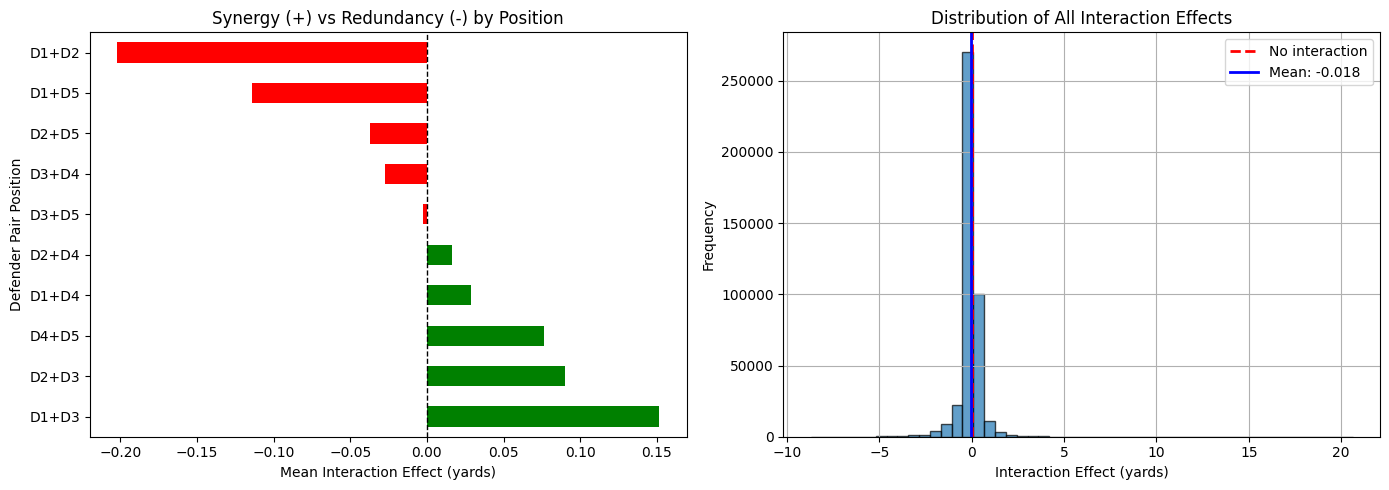

In [69]:
# STATISTICAL SIGNIFICANCE & VISUALIZATION

from scipy import stats
import matplotlib.pyplot as plt

if len(all_interactions_df) > 0:

    print("=" * 70)
    print("STATISTICAL SIGNIFICANCE (t-test: is interaction != 0?)")
    print("=" * 70 + "\n")

    for pair in position_ranking.index:
        pair_data = all_interactions_df[all_interactions_df["defender_pair"] == pair]["interaction_effect"]
        if len(pair_data) >= 10:
            t_stat, p_val = stats.ttest_1samp(pair_data, 0)
            sig = "***" if p_val < 0.01 else "**" if p_val < 0.05 else "*" if p_val < 0.1 else ""
            print(f"{pair}: mean={pair_data.mean():.4f}, t={t_stat:.2f}, p={p_val:.4f} {sig}")

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Plot 1: Bar chart of mean interaction by position pair
    ax1 = axes[0]
    colors = ["green" if x > 0 else "red" for x in position_ranking["mean_interaction"]]
    position_ranking["mean_interaction"].plot(kind="barh", ax=ax1, color=colors)
    ax1.axvline(0, color="black", linestyle="--", linewidth=1)
    ax1.set_xlabel("Mean Interaction Effect (yards)")
    ax1.set_ylabel("Defender Pair Position")
    ax1.set_title("Synergy (+) vs Redundancy (-) by Position")

    # Distribution of interaction effects shows its roughly normal
    ax2 = axes[1]
    all_interactions_df["interaction_effect"].hist(bins=50, ax=ax2, edgecolor="black", alpha=0.7)
    ax2.axvline(0, color="red", linestyle="--", linewidth=2, label="No interaction")
    ax2.axvline(all_interactions_df["interaction_effect"].mean(), color="blue",
                linestyle="-", linewidth=2, label=f'Mean: {all_interactions_df["interaction_effect"].mean():.3f}')
    ax2.set_xlabel("Interaction Effect (yards)")
    ax2.set_ylabel("Frequency")
    ax2.set_title("Distribution of All Interaction Effects")
    ax2.legend()

    plt.tight_layout()
    plt.show()

else:
    print("No data to analyze.")

In [70]:
# COMPARE SYNERGY BY COVERAGE TYPE (MAN vs ZONE)

if len(all_interactions_df) > 0:
    # Get coverage type for each play
    coverage_lookup = final_cleaned_output[["game_id", "play_id", "team_coverage_man_zone"]].drop_duplicates()

    # Merge with interactions
    interactions_with_coverage = all_interactions_df.merge(
        coverage_lookup,
        on=["game_id", "play_id"],
        how="left"
    )

    # Summarize by coverage type and defender pair
    coverage_summary = interactions_with_coverage.groupby(
        ["team_coverage_man_zone", "defender_pair"]
    )["interaction_effect"].agg(["mean", "count"]).round(4)

    coverage_summary.columns = ["mean_interaction", "n_obs"]
    coverage_summary = coverage_summary.reset_index()

    # Pivot for comparison
    pivot_coverage = coverage_summary.pivot(
        index="defender_pair",
        columns="team_coverage_man_zone",
        values="mean_interaction"
    ).round(4)

    # Add difference column if both coverage types exist
    cols = pivot_coverage.columns.tolist()
    if len(cols) >= 2:
        pivot_coverage["difference"] = pivot_coverage[cols[0]] - pivot_coverage[cols[1]]
        pivot_coverage = pivot_coverage.sort_values("difference", ascending=False)

    print("=" * 70)
    print("INTERACTION EFFECTS: MAN vs ZONE COVERAGE")
    print("=" * 70)
    print("\nDoes defender synergy differ by coverage scheme?\n")
    display(pivot_coverage)

else:
    print("Cannot run coverage analysis - missing data.")

INTERACTION EFFECTS: MAN vs ZONE COVERAGE

Does defender synergy differ by coverage scheme?



/tmp/ipython-input-2284493570.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  coverage_summary = interactions_with_coverage.groupby(


team_coverage_man_zone,MAN_COVERAGE,ZONE_COVERAGE,difference
defender_pair,,,
D1+D2,-0.1283,-0.2378,0.1095
D2+D5,0.0102,-0.0546,0.0648
D3+D5,0.0032,-0.0043,0.0075
D4+D5,0.0790,0.0751,0.0039
D1+D3,0.1502,0.1523,-0.0021
D3+D4,-0.0307,-0.0256,-0.0051
D2+D4,0.0067,0.0207,-0.0140
D1+D4,-0.0090,0.0441,-0.0531
D2+D3,0.0503,0.1087,-0.0584


In [80]:
from IPython.display import display
# ============================================================================
# DEFENDER PAIR SYNERGY RANKINGS
# ============================================================================

if len(all_interactions_df) > 0:

    # ------------------------------------------------------------------
    # LOAD PLAYER NAMES FROM ALL TRAIN DATA FILES
    # ------------------------------------------------------------------

    print("Loading player names from ALL training data files...")

    # Loop through ALL input dataframes to build complete player lookup
    player_lookup = {}

    for name, df in dataframes.items():
        if name.startswith('input_'):
            if 'nfl_id' in df.columns and 'player_name' in df.columns:
                # Get unique player id -> name mappings from this file
                player_data = df[['nfl_id', 'player_name']].drop_duplicates()
                player_data = player_data.dropna(subset=['nfl_id', 'player_name'])

                # Add to lookup (will overwrite duplicates, which is fine)
                for _, row in player_data.iterrows():
                    player_lookup[int(row['nfl_id'])] = row['player_name']

                print(f"  Processed {name}: {len(player_data)} players")

    print(f"\nTotal unique players in lookup: {len(player_lookup)}\n")

    def get_player_names(defender_ids_str):
        """Convert '12345,67890' to 'Patrick Surtain + Sauce Gardner'"""
        try:
            ids = defender_ids_str.split(",")
            names = []
            for id_str in ids:
                player_id = int(id_str.strip())
                name = player_lookup.get(player_id, f"ID:{player_id}")
                names.append(name)
            return " + ".join(names)
        except:
            return defender_ids_str

    # ------------------------------------------------------------------
    # RANKING BY DEFENDER POSITION (D1+D2, D1+D3, etc.)
    # ------------------------------------------------------------------
    position_ranking = all_interactions_df.groupby("defender_pair").agg({
        "interaction_effect": ["mean", "std", "count"],
        "actual_pair_effect": "mean",
        "expected_additive": "mean"
    }).round(4)

    position_ranking.columns = ["mean_interaction", "std_interaction", "n_observations",
                                 "mean_actual_pair", "mean_expected_additive"]
    position_ranking["synergy_ratio"] = (
        position_ranking["mean_actual_pair"] /
        position_ranking["mean_expected_additive"].replace(0, np.nan)
    ).round(3)

    position_ranking = position_ranking.sort_values("mean_interaction", ascending=False)

    print("=" * 70)
    print("SYNERGY RANKING BY DEFENDER POSITION")
    print("=" * 70)
    print("\nPositive = SYNERGY (pair works together)")
    print("Negative = REDUNDANCY (pair duplicates effort)")
    print("synergy_ratio > 1 means super-additive\n")
    display(position_ranking)

    # ------------------------------------------------------------------
    # RANKING BY SPECIFIC DEFENDER ID PAIRS (WITH NAMES)
    # ------------------------------------------------------------------
    print("\n" + "=" * 70)
    print("TOP 20 MOST SYNERGISTIC SPECIFIC DEFENDER PAIRS")
    print("=" * 70)

    id_pair_ranking = all_interactions_df.groupby("defender_ids").agg({
        "interaction_effect": ["mean", "count"],
        "defender_pair": "first"
    }).round(4)

    id_pair_ranking.columns = ["mean_interaction", "n_observations", "position_pair"]
    id_pair_ranking = id_pair_ranking[id_pair_ranking["n_observations"] >= 5]
    id_pair_ranking = id_pair_ranking.sort_values("mean_interaction", ascending=False)

    # Add player names column
    id_pair_ranking = id_pair_ranking.reset_index()
    id_pair_ranking["player_names"] = id_pair_ranking["defender_ids"].apply(get_player_names)
    id_pair_ranking = id_pair_ranking.set_index("defender_ids")

    # Reorder columns to show names first
    id_pair_ranking = id_pair_ranking[["player_names", "mean_interaction", "n_observations", "position_pair"]]

    print("\nMost SYNERGISTIC pairs (work well together):\n")
    display(id_pair_ranking.head(20))

    print("\n" + "=" * 70)
    print("TOP 20 MOST REDUNDANT SPECIFIC DEFENDER PAIRS")
    print("=" * 70)
    print("\nMost REDUNDANT pairs (duplicate coverage):\n")
    display(id_pair_ranking.tail(20).sort_values("mean_interaction", ascending=True))

else:
    print("No interaction data to rank.")

Loading player names from ALL training data files...
  Processed input_2023_w09: 671 players
  Processed input_2023_w06: 706 players
  Processed input_2023_w18: 740 players
  Processed input_2023_w01: 737 players
  Processed input_2023_w03: 754 players
  Processed input_2023_w16: 757 players
  Processed input_2023_w04: 750 players
  Processed input_2023_w17: 741 players
  Processed input_2023_w05: 656 players
  Processed input_2023_w07: 611 players
  Processed input_2023_w12: 745 players
  Processed input_2023_w13: 614 players
  Processed input_2023_w08: 740 players
  Processed input_2023_w10: 671 players
  Processed input_2023_w15: 754 players
  Processed input_2023_w14: 704 players
  Processed input_2023_w11: 650 players
  Processed input_2023_w02: 746 players

Total unique players in lookup: 1384

SYNERGY RANKING BY DEFENDER POSITION

Positive = SYNERGY (pair works together)
Negative = REDUNDANCY (pair duplicates effort)
synergy_ratio > 1 means super-additive



,mean_interaction,std_interaction,n_observations,mean_actual_pair,mean_expected_additive,synergy_ratio
defender_pair,,,,,,
D1+D3,0.1517,1.2544,74860,8.0880,7.9364,1.019
D2+D3,0.0899,0.2950,74860,0.5363,0.4465,1.201
D4+D5,0.0761,0.1170,12049,-0.0111,-0.0872,0.127
D1+D4,0.0285,0.4918,34558,8.2331,8.2047,1.003
D2+D4,0.0165,0.2739,34558,0.5916,0.5750,1.029
D3+D5,-0.0023,0.1046,12049,-0.0831,-0.0808,1.028
D3+D4,-0.0271,0.1281,34558,-0.1996,-0.1726,1.156
D2+D5,-0.0372,0.3019,12049,0.7496,0.7868,0.953
D1+D5,-0.1138,0.5139,12049,8.4204,8.5342,0.987



TOP 20 MOST SYNERGISTIC SPECIFIC DEFENDER PAIRS

Most SYNERGISTIC pairs (work well together):



,player_names,mean_interaction,n_observations,position_pair
defender_ids,,,,
"45021,56097",Rudy Ford + Carrington Valentine,6.1803,42,D1+D2
"55978,52411",Clark Phillips III + Jeff Okudah,4.2703,26,D1+D2
"55969,52547",Jakorian Bennett + Amik Robertson,3.9070,37,D1+D2
"46699,46711",Dee Delaney + Ryan Neal,3.1717,50,D1+D2
"53531,56081",Ambry Thomas + Dee Winters,2.4303,25,D1+D2
"39984,46194",Darius Slay + Avonte Maddox,2.3645,93,D1+D2
"55881,55941",Christian Gonzalez + Marte Mapu,2.3611,23,D1+D2
"49410,52535",Jalen Thompson + K'Von Wallace,2.1882,61,D1+D3
"53028,54562",Khalil Dorsey + Kerby Joseph,1.9373,29,D2+D3



TOP 20 MOST REDUNDANT SPECIFIC DEFENDER PAIRS

Most REDUNDANT pairs (duplicate coverage):



,player_names,mean_interaction,n_observations,position_pair
defender_ids,,,,
"54546,43335",Cordale Flott + A'Shawn Robinson,-3.4438,15,D1+D4
"42441,46122",Steven Nelson + M.J. Stewart,-2.8266,68,D1+D2
"46775,55941",J.C. Jackson + Marte Mapu,-2.6515,28,D1+D2
"54708,43413",Jaylen Watson + Deon Bush,-2.6367,7,D1+D3
"55100,42361",Isaiah Pola-Mao + Marcus Peters,-2.5462,21,D1+D2
"56086,55909",Jaylon Jones + Julius Brents,-2.5042,8,D1+D3
"52566,46186",Bryce Hall + Jordan Whitehead,-2.4074,47,D1+D3
"55894,45345",Nolan Smith + Nicholas Morrow,-2.3854,36,D1+D2
"54679,52764",Ja'Sir Taylor + Essang Bassey,-2.3549,37,D1+D2
